In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import matplotlib as mpl
from pylab import cm
import matplotlib.font_manager as fm
from sklearn.feature_selection import mutual_info_regression
from scipy.optimize import minimize,Bounds
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.svm import SVR,NuSVR,LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
import math

### Importação do treino

In [2]:
files = sorted([i for i in os.listdir() if i.find('001')!=-1])
# CRIAÇÃO DOS NOMES DAS COLUNAS
columns_name = ['engine','cicle']+[f'setting_{i+1}' for i in range(3)]+[f'sensor_{i+1}' for i in range(21)]
# IMPORTAÇÃO DO DATA FRAME
df_train = pd.read_csv(files[2],header=None,sep=' ')
# EXCLUI COLUNAS VAZIAS
df_train.drop(columns=[26,27],inplace=True)
# RENOMEIA AS COLUNAS
df_train.columns = columns_name
# CRIA UMA COLUNA DE CICLO MAXIMO PARA CADA MOTOR
df_train = df_train.merge(df_train.groupby('engine').max()['cicle'].reset_index().rename(columns = {'cicle':'max_cicle'}),on='engine',how='left')
# CRIA UMA COLUNA DE ROC PARA CADA LINHA
df_train['ROC'] = df_train['max_cicle'] - df_train['cicle']
# COLUNAS COM BAIXA CORRELAÇÃO COM ROC
df_train.drop(columns=['engine','cicle','max_cicle'],inplace=True)
# SEPARA O DATAFRAME EM X E Y
train_X = df_train.drop(columns='ROC')
train_Y = df_train['ROC']
a = {col:len(train_X[col].unique()) for col in train_X.columns}
a = pd.Series(a)
constants_list = a[a==1].index.tolist()
train_X = train_X.drop(constants_list,axis=1)
# APLICA A REGRESSÃO DE INFORMAÇÃO MUTUA PARA DESCOBRIR AS COLUNAS RELEVANTES PARA O MODELO
res = mutual_info_regression(train_X,train_Y)
mutual_info = pd.Series(dict(zip(train_X.columns.tolist(),res))).sort_values(ascending=False)
columns_list = mutual_info[mutual_info>0.1].index.tolist()
train_X = train_X[columns_list]

Text(0.5, 1.0, 'Mutual Information per Feature')

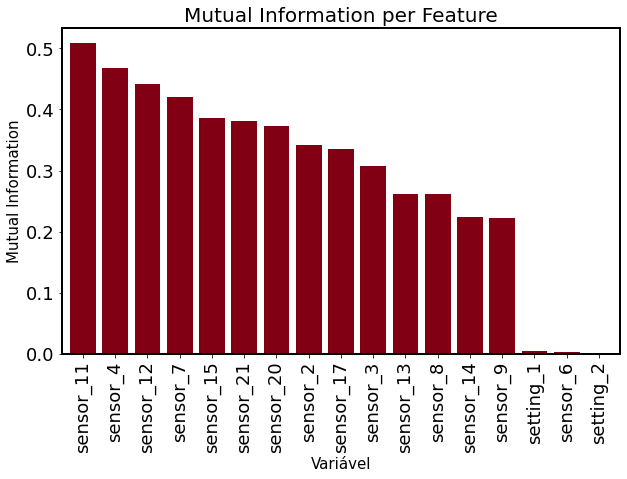

In [3]:
# mpl.rcParams['font.family'] = 'Montserrat'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

colors = ['#'+i for i in ["810014","1c3144"]]

fig,ax = plt.subplots()

mutual_info.plot.bar(figsize=(10,6),color=colors[0],width=0.8)

ax.set_xlabel('Variável',fontsize=15)
ax.set_ylabel('Mutual Information',fontsize=15)
ax.set_title('Mutual Information per Feature',fontsize=20)

# plt.savefig('figuras/mutual_info.png', dpi=300, transparent=True, bbox_inches='tight')


### Importação do teste

In [4]:
# IMPORTAÇÃO DO DATA FRAME
test_X = pd.read_csv(files[1],header=None,sep=' ')
# EXCLUI COLUNAS VAZIAS
test_X.drop(columns=[26,27],inplace=True)
# RENOMEIA AS COLUNAS
test_X.columns = columns_name

test_X = test_X.groupby('engine').last().reset_index()

test_X = test_X[train_X.columns]

test_Y = pd.read_csv(files[0],header=None,sep=' ')[0]

### Dropar colunas com alta e baixa correlação

Tentar fazer algoritimo para otimizar as features
- retirar features até a melhor opção
- adicionar features até a melhor opção

<AxesSubplot:>

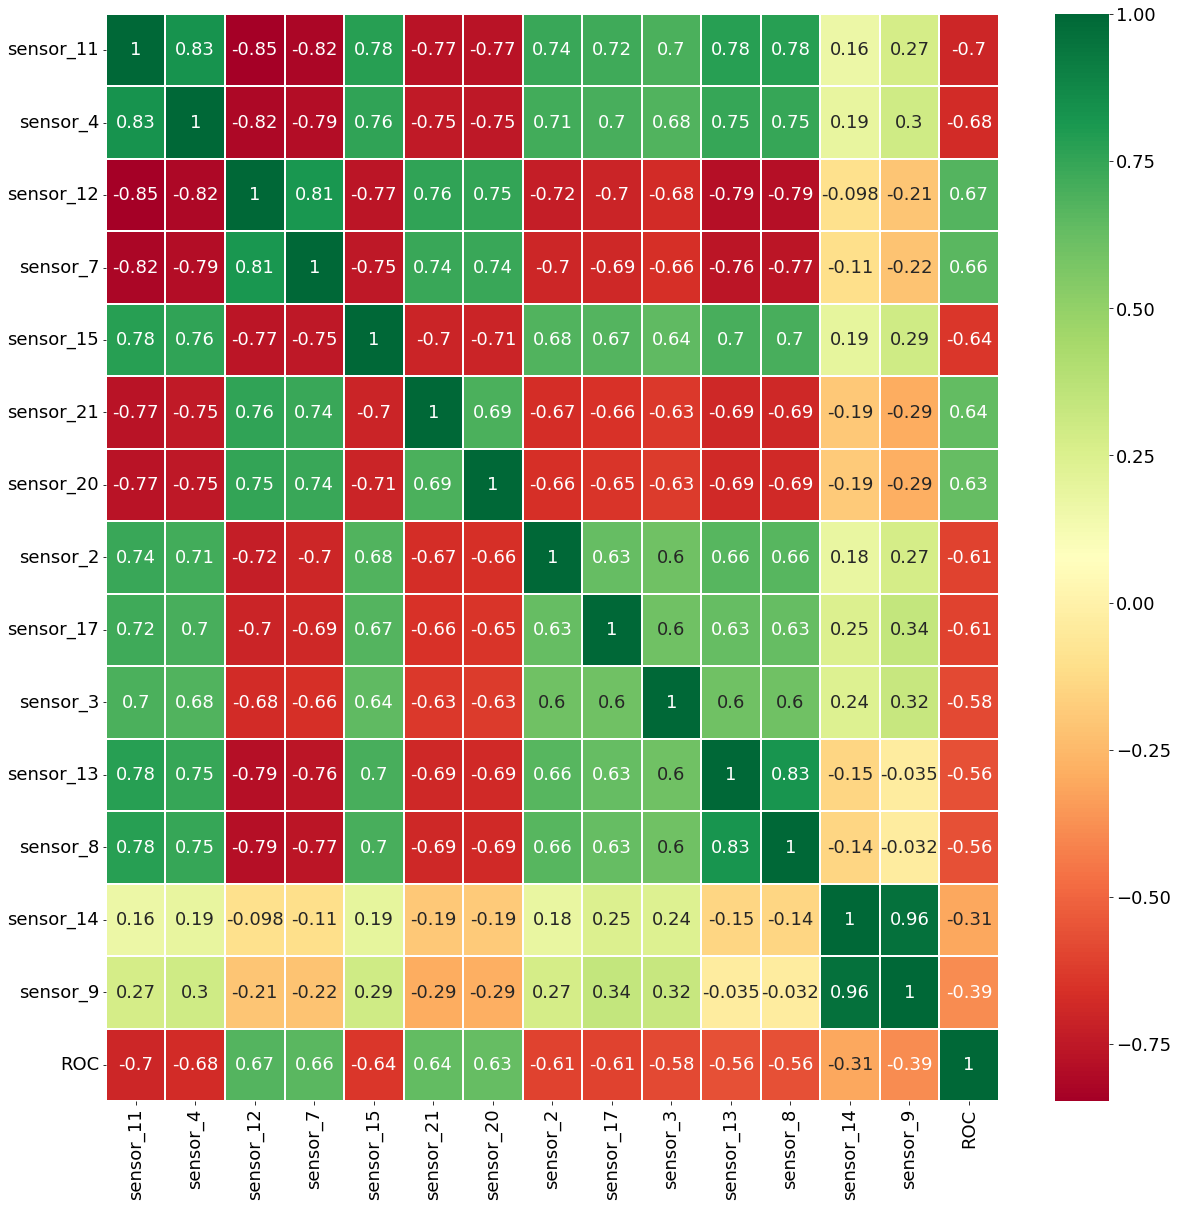

In [6]:
df_train = pd.concat([train_X,train_Y],axis=1)

fig,ax = plt.subplots(figsize=(20,20))
sns.heatmap(df_train.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)

### Avaliar cada coluna

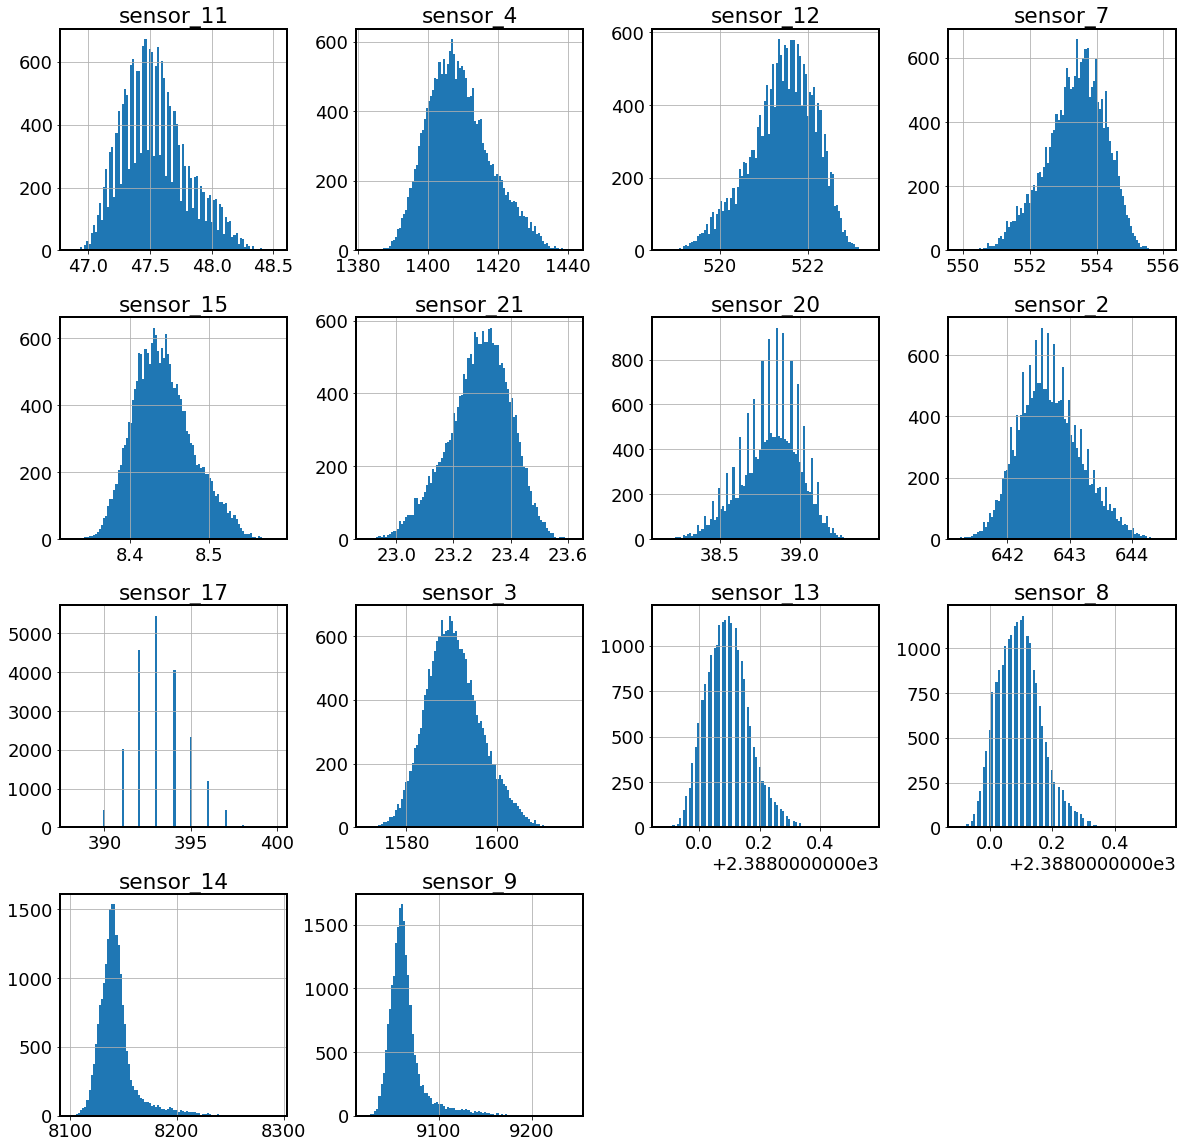

In [7]:
train_X.hist(bins=100,figsize=(20,20));

## PCA

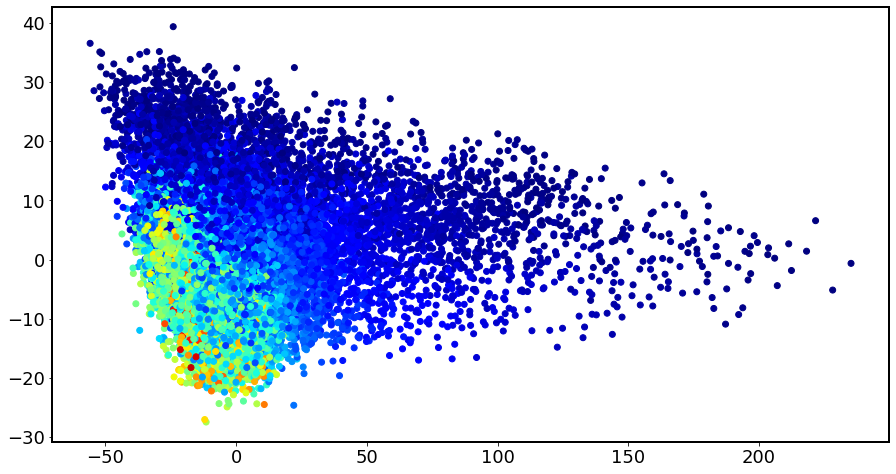

In [8]:
pca = PCA(n_components=2)
pca.fit(np.array(df_train.drop(columns='ROC')))
X = pca.transform(np.array(df_train.drop(columns='ROC')))
norm = plt.Normalize()
colors = plt.cm.jet(norm(df_train['ROC']))
fig,ax = plt.subplots(figsize=(15,8))
ax.scatter(X.T[0],X.T[1],color=colors)

Correlação com o primeiro componente é relativamente alta

In [143]:
pd.concat([pd.DataFrame(X),df_train['ROC']],axis=1).corr()

,0,1,ROC
0,1.000000e+00,1.295868e-14,-0.381517
1,1.295868e-14,1.000000e+00,-0.613988
ROC,-3.815167e-01,-6.139878e-01,1.000000


## Regression

In [5]:
std_scale = StandardScaler().fit(train_X)
train_X_std = pd.DataFrame(std_scale.transform(train_X),columns=train_X.columns)
test_X_std  = pd.DataFrame(std_scale.transform(test_X),columns=test_X.columns)

### Optimização de variaveis

In [6]:
def get_error(current_set):
    regr = LinearSVR(C=0.0098)
    regr.fit(np.array(train_X_std[current_set]), train_Y)
    prediction = regr.predict(np.array(test_X_std[current_set]))
    return loss_score(np.array(test_Y), prediction)
#     return mean_squared_error(np.array(test_Y), prediction)

def SFS(current_set,columns):
    points = {}
    cols_not_in_set = [i for i in columns if i not in current_set]
    for i in cols_not_in_set:
        points[i] = get_error(current_set+[i])
    points = pd.Series(points).sort_values(ascending=True)
    feature = points.index[0]
    error_value = points[0]
    return feature, error_value

def SBS(current_set):
    points = {}
    for i in current_set:
        points[i] = get_error([j for j in current_set if j != i])
    points = pd.Series(points).sort_values(ascending=True)
    feature = points.index[0]
    error_value = points[0]
    return feature, error_value

def get_results_of_list(lista,remove=False):
    if remove:
        results = {}
        for i in range(0,len(lista)):
            results[i] = get_error([j for j in lista if j not in lista[:i]])
        return results
    else:
        results = {}        
        for i in range(1,len(lista)+1):
            results[i-1] = get_error(lista[:i])
        return results            

def loss_score(y_true,y_pred,a1=10,a2=13):
    d = y_pred - y_true
    return np.where(d>=0,np.exp(d/10)-1,np.exp(-d/13)-1).sum()

def get_score(test_Y,prediction):
    print(f'Competition Score: {loss_score(np.array(test_Y), prediction)}')
    print(f'MSE: {mean_squared_error(np.array(test_Y), prediction)}')
    print(f'R2 score: {r2_score(np.array(test_Y), prediction)}')
    print(f'MAE: {mean_absolute_error(np.array(test_Y), prediction)}')
    return [loss_score(np.array(test_Y), prediction),mean_squared_error(np.array(test_Y), prediction),r2_score(np.array(test_Y), prediction),mean_absolute_error(np.array(test_Y), prediction)]

#### SFS algorithim

In [8]:
cols = train_X_std.columns.tolist()
add_set = []
for n in range(len(cols)):
    add_set.append(SFS(add_set,cols)[0])
add_set

['sensor_11',
 'sensor_4',
 'sensor_2',
 'sensor_3',
 'sensor_21',
 'sensor_14',
 'sensor_8',
 'sensor_13',
 'sensor_17',
 'sensor_9',
 'sensor_12',
 'sensor_15',
 'sensor_20',
 'sensor_7']

In [15]:
points_result = pd.Series(get_results_of_list(add_set,remove=False))

columns_to_use = add_set[:points_result.argmin()+1]
columns_to_use

['sensor_11',
 'sensor_4',
 'sensor_2',
 'sensor_3',
 'sensor_21',
 'sensor_14',
 'sensor_8',
 'sensor_13',
 'sensor_17']

In [25]:
a = train_X[columns_to_use].describe().loc[['mean','std']].round(1).T.sort_values('mean',ascending=False).rename(columns={'mean':'Média','std':'Desvio Padrão'})

In [30]:
a.to_clipboard(decimal=',')

In [12]:
full = pd.concat([points_result,sbs_result],axis=1)

full.columns = ['SFS','SBS']

plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

colors = np.array(['#'+i for i in ["810014","1c3144"]])

fig,ax = plt.subplots(figsize=(10,6))

ax.plot(points_result,color=colors[0],lw=5)
ax.plot(sbs_result,color=colors[1],lw=5)

ax.set_xlabel('Variável',fontsize=15)
ax.set_ylabel('Perda',fontsize=15)
ax.set_title('Perda a Cada Variável',fontsize=20)

plt.legend(labels=['SFS','SBS'])

plt.savefig('figuras/SFS.png', dpi=300, transparent=True, bbox_inches='tight')

NameError: name 'sbs_result' is not defined

In [9]:
np.array(columns_to_use)[np.argsort(np.array([int(i.split('_')[1]) for i in columns_to_use]))].tolist()

NameError: name 'columns_to_use' is not defined

#### SBS algorithm

In [16]:
cols = train_X_std.columns.tolist()
start_set = cols[:]
remove_set = []
for n in range(len(cols)-1):
    feature = SBS(start_set)[0]
    start_set.remove(feature)
    remove_set.append(feature)
remove_set

['sensor_7',
 'sensor_20',
 'sensor_15',
 'sensor_12',
 'sensor_3',
 'sensor_9',
 'sensor_17',
 'sensor_13',
 'sensor_2',
 'sensor_21',
 'sensor_8',
 'sensor_14',
 'sensor_4']

In [17]:
sbs_result = pd.Series(get_results_of_list(remove_set,remove=True))

<AxesSubplot:>

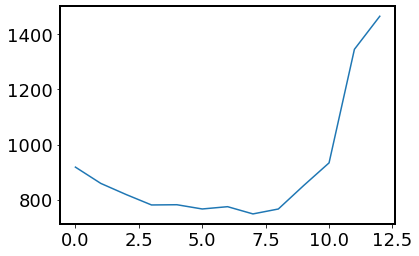

In [18]:
sbs_result.plot()

#### SFFS algorithim

In [76]:
cols = train_X_std.columns.tolist()
add_set = []
k_feaure_number = 12
pontuation = {}
while len(add_set)<k_feaure_number:
    feature, error_value = SFS(add_set,cols)
    add_set.append(feature)
    if (len(add_set) not in list(pontuation.keys())) or (pontuation[len(add_set)][1]>error_value):
        pontuation[len(add_set)] = [add_set[:],error_value]   
    if len(add_set)>2:
        feature, error_value = SBS(add_set)
        if (pontuation[len(add_set)-1][1]>error_value):
            add_set.remove(feature)
            if (pontuation[len(add_set)][1]>error_value):
                pontuation[len(add_set)] = [add_set,error_value]

---

## Modelos

In [61]:
results ={}

In [10]:
train_X = train_X[columns_to_use]
test_X = test_X[columns_to_use]

In [148]:
train_Y = train_Y.astype('float32')

In [11]:
std_scale = StandardScaler().fit(train_X)
train_X_std = pd.DataFrame(std_scale.transform(train_X),columns=train_X.columns)
test_X_std  = pd.DataFrame(std_scale.transform(test_X),columns=train_X.columns)

In [158]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import keras.backend as K

In [382]:
def competition_score(y_true,y_pred):
    d = y_pred - y_true
    zeros = tf.zeros([y_true.shape[1]])
    return (tf.math.exp(tf.maximum(d,zeros)/10)-1) + (tf.math.exp(-1*tf.minimum(d,zeros)/13)-1)

In [401]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
terminate_nan = tf.keras.callbacks.TerminateOnNaN()

In [519]:
def build_model():
#     hp_units = hp.Int('units', min_value=32, max_value=2048, step=32)
    
    model = keras.Sequential([
        layers.Dense(units=train_X_std.shape[1], activation='relu', input_shape=[train_X_std.shape[1]]),
        layers.Dense(units=256, activation='relu'),
        layers.Dropout(0.2),
#         layers.Dense(units=320, activation='relu'),
#         layers.Dropout(0.1),
#         layers.Dense(units=480, activation='relu'),
        layers.Dense(1)
    ])

#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    optimizer = keras.optimizers.Ftrl(learning_rate=1e-2)

    model.compile(loss=competition_score,
                    optimizer=optimizer,
                    metrics=['mse'])
    return model

model = build_model()

history = model.fit(train_X_std, train_Y, epochs=50, validation_split=0.1, batch_size=69)

Epoch 1/50
270/270 [==============================] - 1s 1ms/step - loss: 238520736.0000 - mse: 12374.3271 - val_loss: 61024832.0000 - val_mse: 14514.6738
Epoch 2/50
270/270 [==============================] - 0s 1ms/step - loss: 41799040.0000 - mse: 9701.9990 - val_loss: 24706888.0000 - val_mse: 12654.2910
Epoch 3/50
270/270 [==============================] - 0s 1ms/step - loss: 20414428.0000 - mse: 8605.1211 - val_loss: 14259762.0000 - val_mse: 11589.8818
Epoch 4/50
270/270 [==============================] - 0s 1ms/step - loss: 13480334.0000 - mse: 7952.8652 - val_loss: 9580636.0000 - val_mse: 10848.4629
Epoch 5/50
270/270 [==============================] - 0s 1ms/step - loss: 9075432.0000 - mse: 7433.4868 - val_loss: 7199824.5000 - val_mse: 10329.7178
Epoch 6/50
270/270 [==============================] - 0s 1ms/step - loss: 7481006.5000 - mse: 7128.8198 - val_loss: 5648552.0000 - val_mse: 9897.3174
Epoch 7/50
270/270 [==============================] - 0s 1ms/step - loss: 5725604.5000

In [534]:
history = model.fit(train_X_std, train_Y, epochs=5000, validation_split=0.1, batch_size=69)

Epoch 1/5000
270/270 [==============================] - 0s 1ms/step - loss: 9481.1289 - mse: 2535.8030 - val_loss: 3314.5715 - val_mse: 2876.4265
Epoch 2/5000
270/270 [==============================] - 0s 1ms/step - loss: 11060.0488 - mse: 2541.6663 - val_loss: 3314.1028 - val_mse: 2876.3662
Epoch 3/5000
270/270 [==============================] - 0s 1ms/step - loss: 10845.7471 - mse: 2531.3247 - val_loss: 3314.1460 - val_mse: 2876.3242
Epoch 4/5000
270/270 [==============================] - 0s 1ms/step - loss: 9966.3086 - mse: 2520.9111 - val_loss: 3313.8962 - val_mse: 2876.2556
Epoch 5/5000
270/270 [==============================] - 0s 1ms/step - loss: 10266.9863 - mse: 2537.6289 - val_loss: 3313.8044 - val_mse: 2876.2146
Epoch 6/5000
270/270 [==============================] - 0s 1ms/step - loss: 8713.2334 - mse: 2515.9668 - val_loss: 3313.5334 - val_mse: 2876.1748
Epoch 7/5000
270/270 [==============================] - 0s 1ms/step - loss: 9794.7051 - mse: 2534.5188 - val_loss: 3313.2

270/270 [==============================] - 0s 1ms/step - loss: 10718.6201 - mse: 2530.5991 - val_loss: 3280.9890 - val_mse: 2871.8494
Epoch 112/5000
270/270 [==============================] - 0s 1ms/step - loss: 10833.6943 - mse: 2533.6333 - val_loss: 3280.6182 - val_mse: 2871.8228
Epoch 113/5000
270/270 [==============================] - 0s 1ms/step - loss: 10923.3545 - mse: 2534.4297 - val_loss: 3280.0410 - val_mse: 2871.7842
Epoch 114/5000
270/270 [==============================] - 0s 1ms/step - loss: 11356.0244 - mse: 2530.7793 - val_loss: 3279.4097 - val_mse: 2871.7024
Epoch 115/5000
270/270 [==============================] - 0s 1ms/step - loss: 10889.8232 - mse: 2537.7786 - val_loss: 3278.7280 - val_mse: 2871.6428
Epoch 116/5000
270/270 [==============================] - 0s 1ms/step - loss: 10027.4678 - mse: 2527.6895 - val_loss: 3278.0737 - val_mse: 2871.6299
Epoch 117/5000
270/270 [==============================] - 0s 1ms/step - loss: 10985.3867 - mse: 2534.2656 - val_loss: 327

270/270 [==============================] - 0s 1ms/step - loss: 9453.7646 - mse: 2528.0874 - val_loss: 3244.6404 - val_mse: 2868.1638
Epoch 222/5000
270/270 [==============================] - 0s 1ms/step - loss: 10280.2109 - mse: 2527.9087 - val_loss: 3244.2432 - val_mse: 2868.1677
Epoch 223/5000
270/270 [==============================] - 0s 1ms/step - loss: 10011.1152 - mse: 2531.4304 - val_loss: 3243.7322 - val_mse: 2868.1477
Epoch 224/5000
270/270 [==============================] - 0s 1ms/step - loss: 11104.4766 - mse: 2537.4294 - val_loss: 3243.6987 - val_mse: 2868.1377
Epoch 225/5000
270/270 [==============================] - 0s 1ms/step - loss: 11041.6436 - mse: 2523.7351 - val_loss: 3243.5645 - val_mse: 2868.1357
Epoch 226/5000
270/270 [==============================] - 0s 1ms/step - loss: 9690.3066 - mse: 2524.3789 - val_loss: 3243.0520 - val_mse: 2868.0737
Epoch 227/5000
270/270 [==============================] - 0s 1ms/step - loss: 9093.6143 - mse: 2525.2358 - val_loss: 3242.4

270/270 [==============================] - 0s 1ms/step - loss: 8964.2041 - mse: 2521.4216 - val_loss: 3217.4209 - val_mse: 2864.5188
Epoch 332/5000
270/270 [==============================] - 0s 1ms/step - loss: 10675.8525 - mse: 2530.2888 - val_loss: 3217.3899 - val_mse: 2864.4631
Epoch 333/5000
270/270 [==============================] - 0s 1ms/step - loss: 10096.8447 - mse: 2521.6091 - val_loss: 3217.0012 - val_mse: 2864.4050
Epoch 334/5000
270/270 [==============================] - 0s 1ms/step - loss: 9052.1758 - mse: 2523.8120 - val_loss: 3216.6777 - val_mse: 2864.3484
Epoch 335/5000
270/270 [==============================] - 0s 1ms/step - loss: 9198.3154 - mse: 2522.3425 - val_loss: 3216.4021 - val_mse: 2864.3237
Epoch 336/5000
270/270 [==============================] - 0s 1ms/step - loss: 11209.7012 - mse: 2525.8267 - val_loss: 3216.2283 - val_mse: 2864.3572
Epoch 337/5000
270/270 [==============================] - 0s 1ms/step - loss: 9509.5762 - mse: 2519.4023 - val_loss: 3215.70

270/270 [==============================] - 0s 1ms/step - loss: 10379.3467 - mse: 2523.1426 - val_loss: 3194.5232 - val_mse: 2860.8047
Epoch 442/5000
270/270 [==============================] - 0s 1ms/step - loss: 10389.6465 - mse: 2510.3921 - val_loss: 3193.9324 - val_mse: 2860.7407
Epoch 443/5000
270/270 [==============================] - 0s 1ms/step - loss: 10074.7256 - mse: 2526.8210 - val_loss: 3193.6655 - val_mse: 2860.7002
Epoch 444/5000
270/270 [==============================] - 0s 1ms/step - loss: 9660.5166 - mse: 2523.9502 - val_loss: 3193.1584 - val_mse: 2860.6780
Epoch 445/5000
270/270 [==============================] - 0s 1ms/step - loss: 10976.2490 - mse: 2512.8354 - val_loss: 3192.5444 - val_mse: 2860.6343
Epoch 446/5000
270/270 [==============================] - 0s 1ms/step - loss: 10945.8555 - mse: 2514.6174 - val_loss: 3191.9292 - val_mse: 2860.6218
Epoch 447/5000
270/270 [==============================] - 0s 1ms/step - loss: 10078.7979 - mse: 2521.3396 - val_loss: 3191

270/270 [==============================] - 0s 1ms/step - loss: 10775.0059 - mse: 2522.8684 - val_loss: 3161.6602 - val_mse: 2857.3110
Epoch 552/5000
270/270 [==============================] - 0s 1ms/step - loss: 9735.7178 - mse: 2506.7634 - val_loss: 3161.5110 - val_mse: 2857.2859
Epoch 553/5000
270/270 [==============================] - 0s 1ms/step - loss: 9751.8291 - mse: 2518.1377 - val_loss: 3160.7617 - val_mse: 2857.2590
Epoch 554/5000
270/270 [==============================] - 0s 1ms/step - loss: 8485.6074 - mse: 2510.8215 - val_loss: 3160.2324 - val_mse: 2857.2410
Epoch 555/5000
270/270 [==============================] - 0s 1ms/step - loss: 9801.0938 - mse: 2513.9329 - val_loss: 3159.9722 - val_mse: 2857.2495
Epoch 556/5000
270/270 [==============================] - 0s 1ms/step - loss: 10451.0801 - mse: 2503.8469 - val_loss: 3159.4834 - val_mse: 2857.2012
Epoch 557/5000
270/270 [==============================] - 0s 1ms/step - loss: 11702.8564 - mse: 2518.9856 - val_loss: 3159.24

270/270 [==============================] - 0s 1ms/step - loss: 8738.2559 - mse: 2519.5564 - val_loss: 3132.2688 - val_mse: 2853.7644
Epoch 662/5000
270/270 [==============================] - 0s 1ms/step - loss: 9359.5479 - mse: 2508.1370 - val_loss: 3131.8250 - val_mse: 2853.7168
Epoch 663/5000
270/270 [==============================] - 0s 1ms/step - loss: 10818.0781 - mse: 2511.2373 - val_loss: 3131.2864 - val_mse: 2853.6772
Epoch 664/5000
270/270 [==============================] - 0s 1ms/step - loss: 9306.4980 - mse: 2503.2188 - val_loss: 3130.9683 - val_mse: 2853.6580
Epoch 665/5000
270/270 [==============================] - 0s 1ms/step - loss: 10450.2734 - mse: 2507.0649 - val_loss: 3130.6001 - val_mse: 2853.6143
Epoch 666/5000
270/270 [==============================] - 0s 1ms/step - loss: 9833.9238 - mse: 2508.9824 - val_loss: 3130.2280 - val_mse: 2853.5906
Epoch 667/5000
270/270 [==============================] - 0s 1ms/step - loss: 10130.0557 - mse: 2510.7100 - val_loss: 3130.25

270/270 [==============================] - 0s 1ms/step - loss: 8745.0137 - mse: 2498.4458 - val_loss: 3107.4758 - val_mse: 2850.3083
Epoch 772/5000
270/270 [==============================] - 0s 1ms/step - loss: 9810.2314 - mse: 2512.5383 - val_loss: 3107.4795 - val_mse: 2850.2568
Epoch 773/5000
270/270 [==============================] - 0s 1ms/step - loss: 10439.1484 - mse: 2510.5239 - val_loss: 3107.0098 - val_mse: 2850.2058
Epoch 774/5000
270/270 [==============================] - 0s 1ms/step - loss: 9612.2949 - mse: 2509.3508 - val_loss: 3107.0598 - val_mse: 2850.1814
Epoch 775/5000
270/270 [==============================] - 0s 1ms/step - loss: 9286.4512 - mse: 2499.8020 - val_loss: 3106.5757 - val_mse: 2850.1328
Epoch 776/5000
270/270 [==============================] - 0s 1ms/step - loss: 10281.9453 - mse: 2502.4241 - val_loss: 3106.4336 - val_mse: 2850.0942
Epoch 777/5000
270/270 [==============================] - 0s 1ms/step - loss: 10368.4180 - mse: 2501.3911 - val_loss: 3105.85

270/270 [==============================] - 0s 1ms/step - loss: 9029.1465 - mse: 2504.1455 - val_loss: 3074.8811 - val_mse: 2845.8557
Epoch 882/5000
270/270 [==============================] - 0s 1ms/step - loss: 9148.0889 - mse: 2501.9592 - val_loss: 3074.6633 - val_mse: 2845.8186
Epoch 883/5000
270/270 [==============================] - 0s 1ms/step - loss: 10910.2979 - mse: 2502.5356 - val_loss: 3074.2029 - val_mse: 2845.7937
Epoch 884/5000
270/270 [==============================] - 0s 1ms/step - loss: 9645.1943 - mse: 2512.8059 - val_loss: 3074.1455 - val_mse: 2845.7520
Epoch 885/5000
270/270 [==============================] - 0s 1ms/step - loss: 9942.0684 - mse: 2504.2830 - val_loss: 3073.7612 - val_mse: 2845.6968
Epoch 886/5000
270/270 [==============================] - 0s 1ms/step - loss: 8739.2578 - mse: 2516.1416 - val_loss: 3073.3594 - val_mse: 2845.6689
Epoch 887/5000
270/270 [==============================] - 0s 1ms/step - loss: 9597.1797 - mse: 2504.4924 - val_loss: 3072.7820

270/270 [==============================] - 0s 1ms/step - loss: 9561.3848 - mse: 2497.6746 - val_loss: 3056.4727 - val_mse: 2842.4456
Epoch 992/5000
270/270 [==============================] - 0s 1ms/step - loss: 9845.1758 - mse: 2506.6003 - val_loss: 3056.1096 - val_mse: 2842.4036
Epoch 993/5000
270/270 [==============================] - 0s 1ms/step - loss: 10223.2002 - mse: 2509.6116 - val_loss: 3055.5232 - val_mse: 2842.3691
Epoch 994/5000
270/270 [==============================] - 0s 1ms/step - loss: 9224.0908 - mse: 2504.2441 - val_loss: 3055.3142 - val_mse: 2842.3677
Epoch 995/5000
270/270 [==============================] - 0s 1ms/step - loss: 10237.9219 - mse: 2507.4431 - val_loss: 3055.4604 - val_mse: 2842.3489
Epoch 996/5000
270/270 [==============================] - 0s 1ms/step - loss: 10286.5342 - mse: 2502.2104 - val_loss: 3055.3540 - val_mse: 2842.3264
Epoch 997/5000
270/270 [==============================] - 0s 1ms/step - loss: 8931.9531 - mse: 2510.4854 - val_loss: 3055.38

270/270 [==============================] - 0s 1ms/step - loss: 9267.6426 - mse: 2513.1091 - val_loss: 3041.2856 - val_mse: 2840.5955
Epoch 1047/5000
270/270 [==============================] - 0s 1ms/step - loss: 8972.1025 - mse: 2507.9202 - val_loss: 3040.9854 - val_mse: 2840.5845
Epoch 1048/5000
270/270 [==============================] - 0s 1ms/step - loss: 11870.1982 - mse: 2501.4797 - val_loss: 3040.3479 - val_mse: 2840.5291
Epoch 1049/5000
270/270 [==============================] - 0s 1ms/step - loss: 9796.8857 - mse: 2508.3860 - val_loss: 3039.9314 - val_mse: 2840.4985
Epoch 1050/5000
270/270 [==============================] - 0s 1ms/step - loss: 9317.5664 - mse: 2504.0405 - val_loss: 3039.6370 - val_mse: 2840.4717
Epoch 1051/5000
270/270 [==============================] - 0s 1ms/step - loss: 8751.6982 - mse: 2495.0496 - val_loss: 3039.1384 - val_mse: 2840.4456
Epoch 1052/5000
270/270 [==============================] - 0s 1ms/step - loss: 9375.4590 - mse: 2499.9888 - val_loss: 303

Epoch 1101/5000
270/270 [==============================] - 0s 1ms/step - loss: 9135.3125 - mse: 2497.4773 - val_loss: 3032.3706 - val_mse: 2839.1458
Epoch 1102/5000
270/270 [==============================] - 0s 1ms/step - loss: 9452.5537 - mse: 2512.8438 - val_loss: 3032.1370 - val_mse: 2839.1423
Epoch 1103/5000
270/270 [==============================] - 0s 1ms/step - loss: 9331.9844 - mse: 2495.2710 - val_loss: 3032.4976 - val_mse: 2839.1213
Epoch 1104/5000
270/270 [==============================] - 0s 1ms/step - loss: 9556.9033 - mse: 2511.4150 - val_loss: 3032.1394 - val_mse: 2839.0925
Epoch 1105/5000
270/270 [==============================] - 0s 1ms/step - loss: 10357.0752 - mse: 2501.0872 - val_loss: 3032.3328 - val_mse: 2839.0493
Epoch 1106/5000
270/270 [==============================] - 0s 1ms/step - loss: 9036.7344 - mse: 2500.6848 - val_loss: 3032.0376 - val_mse: 2839.0518
Epoch 1107/5000
270/270 [==============================] - 0s 1ms/step - loss: 13481.4629 - mse: 2506.163

Epoch 1156/5000
270/270 [==============================] - 0s 2ms/step - loss: 10118.0996 - mse: 2498.3066 - val_loss: 3025.4402 - val_mse: 2837.6624
Epoch 1157/5000
270/270 [==============================] - 0s 1ms/step - loss: 9152.9502 - mse: 2496.5173 - val_loss: 3025.2688 - val_mse: 2837.6423
Epoch 1158/5000
270/270 [==============================] - 0s 2ms/step - loss: 10527.4482 - mse: 2504.7334 - val_loss: 3025.5317 - val_mse: 2837.5742
Epoch 1159/5000
270/270 [==============================] - 0s 1ms/step - loss: 10071.2812 - mse: 2503.5747 - val_loss: 3025.9565 - val_mse: 2837.5505
Epoch 1160/5000
270/270 [==============================] - 0s 2ms/step - loss: 8954.7021 - mse: 2507.4683 - val_loss: 3025.7607 - val_mse: 2837.5320
Epoch 1161/5000
270/270 [==============================] - 0s 1ms/step - loss: 9451.2949 - mse: 2492.4697 - val_loss: 3025.3853 - val_mse: 2837.5098
Epoch 1162/5000
270/270 [==============================] - 0s 1ms/step - loss: 8230.7754 - mse: 2493.26

Epoch 1211/5000
270/270 [==============================] - 0s 1ms/step - loss: 8668.9834 - mse: 2495.4561 - val_loss: 3015.5776 - val_mse: 2836.0913
Epoch 1212/5000
270/270 [==============================] - 0s 1ms/step - loss: 10834.1621 - mse: 2498.1494 - val_loss: 3015.6646 - val_mse: 2836.0803
Epoch 1213/5000
270/270 [==============================] - 0s 1ms/step - loss: 9671.8750 - mse: 2501.7642 - val_loss: 3015.3528 - val_mse: 2836.0422
Epoch 1214/5000
270/270 [==============================] - 0s 1ms/step - loss: 10154.5469 - mse: 2499.4932 - val_loss: 3014.9587 - val_mse: 2835.9917
Epoch 1215/5000
270/270 [==============================] - 0s 1ms/step - loss: 9934.5742 - mse: 2490.7656 - val_loss: 3014.6741 - val_mse: 2835.9814
Epoch 1216/5000
270/270 [==============================] - 0s 1ms/step - loss: 9699.8887 - mse: 2496.8931 - val_loss: 3014.5117 - val_mse: 2835.9480
Epoch 1217/5000
270/270 [==============================] - 0s 1ms/step - loss: 11129.3477 - mse: 2493.35

Epoch 1266/5000
270/270 [==============================] - 0s 1ms/step - loss: 8651.0439 - mse: 2495.5583 - val_loss: 3004.2881 - val_mse: 2834.6074
Epoch 1267/5000
270/270 [==============================] - 0s 1ms/step - loss: 9105.1758 - mse: 2494.4351 - val_loss: 3003.8337 - val_mse: 2834.5586
Epoch 1268/5000
270/270 [==============================] - 0s 1ms/step - loss: 10649.4707 - mse: 2499.2842 - val_loss: 3003.8813 - val_mse: 2834.5339
Epoch 1269/5000
270/270 [==============================] - 0s 1ms/step - loss: 9021.4863 - mse: 2496.3655 - val_loss: 3003.5115 - val_mse: 2834.5066
Epoch 1270/5000
270/270 [==============================] - 0s 1ms/step - loss: 9451.6230 - mse: 2496.3770 - val_loss: 3003.1367 - val_mse: 2834.4998
Epoch 1271/5000
270/270 [==============================] - 0s 1ms/step - loss: 9388.4473 - mse: 2505.6353 - val_loss: 3002.7634 - val_mse: 2834.4617
Epoch 1272/5000
270/270 [==============================] - 0s 1ms/step - loss: 8871.2598 - mse: 2488.6067

Epoch 1321/5000
270/270 [==============================] - 0s 1ms/step - loss: 9574.0898 - mse: 2500.7981 - val_loss: 2993.2195 - val_mse: 2832.7979
Epoch 1322/5000
270/270 [==============================] - 0s 1ms/step - loss: 8993.8037 - mse: 2498.9866 - val_loss: 2992.9351 - val_mse: 2832.7507
Epoch 1323/5000
270/270 [==============================] - 0s 1ms/step - loss: 9583.1475 - mse: 2485.8684 - val_loss: 2992.4424 - val_mse: 2832.7190
Epoch 1324/5000
270/270 [==============================] - 0s 1ms/step - loss: 11007.8174 - mse: 2501.6797 - val_loss: 2992.3013 - val_mse: 2832.7126
Epoch 1325/5000
270/270 [==============================] - 0s 1ms/step - loss: 10106.4268 - mse: 2493.7703 - val_loss: 2993.7937 - val_mse: 2832.7021
Epoch 1326/5000
270/270 [==============================] - 0s 1ms/step - loss: 9848.9482 - mse: 2495.4854 - val_loss: 2993.2722 - val_mse: 2832.6853
Epoch 1327/5000
270/270 [==============================] - 0s 1ms/step - loss: 8870.7988 - mse: 2498.428

Epoch 1376/5000
270/270 [==============================] - 0s 1ms/step - loss: 8614.3057 - mse: 2495.7917 - val_loss: 2987.8462 - val_mse: 2831.4768
Epoch 1377/5000
270/270 [==============================] - 0s 1ms/step - loss: 10279.9912 - mse: 2500.4028 - val_loss: 2987.6052 - val_mse: 2831.4727
Epoch 1378/5000
270/270 [==============================] - 0s 1ms/step - loss: 8571.6104 - mse: 2490.6257 - val_loss: 2987.0498 - val_mse: 2831.4292
Epoch 1379/5000
270/270 [==============================] - 0s 1ms/step - loss: 8232.6377 - mse: 2493.9219 - val_loss: 2986.8977 - val_mse: 2831.3899
Epoch 1380/5000
270/270 [==============================] - 0s 1ms/step - loss: 11297.3643 - mse: 2486.8281 - val_loss: 2986.1982 - val_mse: 2831.4531
Epoch 1381/5000
270/270 [==============================] - 0s 1ms/step - loss: 9216.6064 - mse: 2490.9377 - val_loss: 2986.0125 - val_mse: 2831.4573
Epoch 1382/5000
270/270 [==============================] - 0s 1ms/step - loss: 10195.3711 - mse: 2503.26

Epoch 1431/5000
270/270 [==============================] - 0s 1ms/step - loss: 10364.9971 - mse: 2496.2771 - val_loss: 2975.6682 - val_mse: 2830.3374
Epoch 1432/5000
270/270 [==============================] - 0s 1ms/step - loss: 8327.2646 - mse: 2493.2791 - val_loss: 2975.2058 - val_mse: 2830.3076
Epoch 1433/5000
270/270 [==============================] - 0s 1ms/step - loss: 9163.1084 - mse: 2501.5620 - val_loss: 2974.7068 - val_mse: 2830.2649
Epoch 1434/5000
270/270 [==============================] - 0s 1ms/step - loss: 12393.6084 - mse: 2503.3118 - val_loss: 2976.4436 - val_mse: 2830.2527
Epoch 1435/5000
270/270 [==============================] - 0s 1ms/step - loss: 8657.7822 - mse: 2493.7119 - val_loss: 2976.0308 - val_mse: 2830.2427
Epoch 1436/5000
270/270 [==============================] - 0s 1ms/step - loss: 10256.3623 - mse: 2495.2185 - val_loss: 2975.5635 - val_mse: 2830.2026
Epoch 1437/5000
270/270 [==============================] - 0s 1ms/step - loss: 8531.3018 - mse: 2496.62

Epoch 1486/5000
270/270 [==============================] - 0s 1ms/step - loss: 9626.6689 - mse: 2489.6123 - val_loss: 2966.5315 - val_mse: 2828.7021
Epoch 1487/5000
270/270 [==============================] - 0s 1ms/step - loss: 9854.2617 - mse: 2486.1465 - val_loss: 2966.6091 - val_mse: 2828.6792
Epoch 1488/5000
270/270 [==============================] - 0s 1ms/step - loss: 8666.9736 - mse: 2485.3713 - val_loss: 2966.1055 - val_mse: 2828.6499
Epoch 1489/5000
270/270 [==============================] - 0s 1ms/step - loss: 9706.8936 - mse: 2500.7031 - val_loss: 2965.9236 - val_mse: 2828.6074
Epoch 1490/5000
270/270 [==============================] - 0s 1ms/step - loss: 9824.3896 - mse: 2499.8469 - val_loss: 2965.8843 - val_mse: 2828.6096
Epoch 1491/5000
270/270 [==============================] - 0s 1ms/step - loss: 8596.3027 - mse: 2494.5864 - val_loss: 2965.7178 - val_mse: 2828.5742
Epoch 1492/5000
270/270 [==============================] - 0s 1ms/step - loss: 8517.0664 - mse: 2494.9434 

Epoch 1541/5000
270/270 [==============================] - 0s 1ms/step - loss: 9921.4512 - mse: 2492.5352 - val_loss: 2952.3491 - val_mse: 2827.5706
Epoch 1542/5000
270/270 [==============================] - 0s 1ms/step - loss: 8551.7715 - mse: 2496.9741 - val_loss: 2952.0374 - val_mse: 2827.5215
Epoch 1543/5000
270/270 [==============================] - 0s 1ms/step - loss: 9608.0518 - mse: 2501.0596 - val_loss: 2951.5779 - val_mse: 2827.5127
Epoch 1544/5000
270/270 [==============================] - 0s 1ms/step - loss: 9167.6396 - mse: 2491.3855 - val_loss: 2951.5544 - val_mse: 2827.4524
Epoch 1545/5000
270/270 [==============================] - 0s 1ms/step - loss: 10144.8945 - mse: 2502.2300 - val_loss: 2951.7358 - val_mse: 2827.4329
Epoch 1546/5000
270/270 [==============================] - 0s 1ms/step - loss: 8655.3037 - mse: 2486.2356 - val_loss: 2951.3345 - val_mse: 2827.3884
Epoch 1547/5000
270/270 [==============================] - 0s 1ms/step - loss: 10157.8438 - mse: 2489.755

Epoch 1596/5000
270/270 [==============================] - 0s 1ms/step - loss: 8970.2881 - mse: 2478.1892 - val_loss: 2942.4460 - val_mse: 2826.1506
Epoch 1597/5000
270/270 [==============================] - 0s 2ms/step - loss: 12596.9561 - mse: 2496.2932 - val_loss: 2945.4727 - val_mse: 2826.2307
Epoch 1598/5000
270/270 [==============================] - 0s 2ms/step - loss: 9748.5117 - mse: 2491.4434 - val_loss: 2945.2466 - val_mse: 2826.2625
Epoch 1599/5000
270/270 [==============================] - 0s 1ms/step - loss: 9309.4531 - mse: 2490.6172 - val_loss: 2944.9458 - val_mse: 2826.2307
Epoch 1600/5000
270/270 [==============================] - 0s 1ms/step - loss: 9299.8213 - mse: 2499.7083 - val_loss: 2945.2705 - val_mse: 2826.2112
Epoch 1601/5000
270/270 [==============================] - 0s 1ms/step - loss: 9369.7432 - mse: 2488.0381 - val_loss: 2945.2837 - val_mse: 2826.2075
Epoch 1602/5000
270/270 [==============================] - 0s 1ms/step - loss: 9864.2773 - mse: 2488.6543

Epoch 1651/5000
270/270 [==============================] - 0s 1ms/step - loss: 9198.4824 - mse: 2479.7085 - val_loss: 2934.1482 - val_mse: 2824.7964
Epoch 1652/5000
270/270 [==============================] - 0s 1ms/step - loss: 8395.4961 - mse: 2487.0676 - val_loss: 2933.8018 - val_mse: 2824.7871
Epoch 1653/5000
270/270 [==============================] - 0s 1ms/step - loss: 9703.4414 - mse: 2471.2788 - val_loss: 2933.3745 - val_mse: 2824.7991
Epoch 1654/5000
270/270 [==============================] - 0s 1ms/step - loss: 8682.4561 - mse: 2475.7468 - val_loss: 2933.0439 - val_mse: 2824.7725
Epoch 1655/5000
270/270 [==============================] - 0s 1ms/step - loss: 9584.5625 - mse: 2482.8337 - val_loss: 2932.6553 - val_mse: 2824.7585
Epoch 1656/5000
270/270 [==============================] - 0s 1ms/step - loss: 8477.8633 - mse: 2496.1685 - val_loss: 2932.3682 - val_mse: 2824.7239
Epoch 1657/5000
270/270 [==============================] - 0s 1ms/step - loss: 9179.7246 - mse: 2484.1724 

Epoch 1706/5000
270/270 [==============================] - 0s 1ms/step - loss: 8433.2861 - mse: 2482.3557 - val_loss: 2923.1719 - val_mse: 2823.4751
Epoch 1707/5000
270/270 [==============================] - 0s 1ms/step - loss: 9054.1494 - mse: 2483.8633 - val_loss: 2922.7285 - val_mse: 2823.4636
Epoch 1708/5000
270/270 [==============================] - 0s 1ms/step - loss: 10073.4707 - mse: 2487.9788 - val_loss: 2922.7949 - val_mse: 2823.4360
Epoch 1709/5000
270/270 [==============================] - 0s 1ms/step - loss: 9716.1875 - mse: 2485.1936 - val_loss: 2922.6072 - val_mse: 2823.4536
Epoch 1710/5000
270/270 [==============================] - 0s 2ms/step - loss: 9393.2207 - mse: 2478.3513 - val_loss: 2922.3105 - val_mse: 2823.4172
Epoch 1711/5000
270/270 [==============================] - 0s 2ms/step - loss: 8969.2051 - mse: 2477.0537 - val_loss: 2922.1013 - val_mse: 2823.3721
Epoch 1712/5000
270/270 [==============================] - 0s 1ms/step - loss: 9914.0010 - mse: 2483.8892

Epoch 1761/5000
270/270 [==============================] - 0s 1ms/step - loss: 8831.7666 - mse: 2487.8013 - val_loss: 2916.5107 - val_mse: 2822.2388
Epoch 1762/5000
270/270 [==============================] - 0s 1ms/step - loss: 8792.3936 - mse: 2483.3831 - val_loss: 2916.2571 - val_mse: 2822.1963
Epoch 1763/5000
270/270 [==============================] - 0s 1ms/step - loss: 9306.9902 - mse: 2483.2109 - val_loss: 2916.7678 - val_mse: 2822.1614
Epoch 1764/5000
270/270 [==============================] - 0s 1ms/step - loss: 8272.9395 - mse: 2482.1104 - val_loss: 2916.4563 - val_mse: 2822.1350
Epoch 1765/5000
270/270 [==============================] - 0s 1ms/step - loss: 9422.9395 - mse: 2480.8926 - val_loss: 2916.0754 - val_mse: 2822.1333
Epoch 1766/5000
270/270 [==============================] - 0s 1ms/step - loss: 9284.1211 - mse: 2483.6694 - val_loss: 2916.1360 - val_mse: 2822.1218
Epoch 1767/5000
270/270 [==============================] - 0s 1ms/step - loss: 8533.3057 - mse: 2485.7742 

Epoch 1816/5000
270/270 [==============================] - 0s 1ms/step - loss: 7640.9404 - mse: 2471.6331 - val_loss: 2904.4316 - val_mse: 2821.0532
Epoch 1817/5000
270/270 [==============================] - 0s 1ms/step - loss: 9704.4766 - mse: 2476.9116 - val_loss: 2904.6987 - val_mse: 2821.0342
Epoch 1818/5000
270/270 [==============================] - 0s 1ms/step - loss: 8792.7080 - mse: 2484.2158 - val_loss: 2904.3872 - val_mse: 2820.9858
Epoch 1819/5000
270/270 [==============================] - 0s 1ms/step - loss: 9146.9180 - mse: 2482.0737 - val_loss: 2903.8381 - val_mse: 2820.9668
Epoch 1820/5000
270/270 [==============================] - 0s 1ms/step - loss: 8531.2031 - mse: 2477.8474 - val_loss: 2903.6501 - val_mse: 2820.9644
Epoch 1821/5000
270/270 [==============================] - 0s 1ms/step - loss: 9688.8838 - mse: 2479.9097 - val_loss: 2903.2188 - val_mse: 2820.9189
Epoch 1822/5000
270/270 [==============================] - 0s 2ms/step - loss: 8626.7480 - mse: 2468.1042 

Epoch 1871/5000
270/270 [==============================] - 0s 1ms/step - loss: 9462.4912 - mse: 2475.6501 - val_loss: 2895.9272 - val_mse: 2819.5789
Epoch 1872/5000
270/270 [==============================] - 0s 1ms/step - loss: 8775.6553 - mse: 2483.2104 - val_loss: 2895.6140 - val_mse: 2819.5542
Epoch 1873/5000
270/270 [==============================] - 0s 1ms/step - loss: 9391.3574 - mse: 2478.6494 - val_loss: 2895.5371 - val_mse: 2819.5432
Epoch 1874/5000
270/270 [==============================] - 0s 1ms/step - loss: 8211.0674 - mse: 2472.1033 - val_loss: 2895.4089 - val_mse: 2819.5181
Epoch 1875/5000
270/270 [==============================] - 0s 1ms/step - loss: 8864.7734 - mse: 2477.3911 - val_loss: 2895.1296 - val_mse: 2819.4929
Epoch 1876/5000
270/270 [==============================] - 0s 1ms/step - loss: 8347.0049 - mse: 2477.5474 - val_loss: 2894.7466 - val_mse: 2819.4622
Epoch 1877/5000
270/270 [==============================] - 0s 1ms/step - loss: 7604.7588 - mse: 2480.7737 

Epoch 1926/5000
270/270 [==============================] - 0s 1ms/step - loss: 9337.7275 - mse: 2480.7366 - val_loss: 2881.9490 - val_mse: 2818.0522
Epoch 1927/5000
270/270 [==============================] - 0s 1ms/step - loss: 8517.8281 - mse: 2485.8901 - val_loss: 2881.5996 - val_mse: 2818.0222
Epoch 1928/5000
270/270 [==============================] - 0s 1ms/step - loss: 8454.2676 - mse: 2473.9365 - val_loss: 2881.3762 - val_mse: 2817.9934
Epoch 1929/5000
270/270 [==============================] - 0s 1ms/step - loss: 8301.2207 - mse: 2489.0579 - val_loss: 2880.9548 - val_mse: 2817.9673
Epoch 1930/5000
270/270 [==============================] - 0s 1ms/step - loss: 9182.5830 - mse: 2480.7993 - val_loss: 2880.9780 - val_mse: 2817.9368
Epoch 1931/5000
270/270 [==============================] - 0s 1ms/step - loss: 8908.6738 - mse: 2474.6028 - val_loss: 2881.2288 - val_mse: 2817.9058
Epoch 1932/5000
270/270 [==============================] - 0s 1ms/step - loss: 9106.2705 - mse: 2470.9033 

Epoch 1981/5000
270/270 [==============================] - 0s 1ms/step - loss: 7757.2529 - mse: 2476.1389 - val_loss: 2874.2512 - val_mse: 2816.6887
Epoch 1982/5000
270/270 [==============================] - 0s 1ms/step - loss: 8921.2188 - mse: 2470.2249 - val_loss: 2874.1528 - val_mse: 2816.6731
Epoch 1983/5000
270/270 [==============================] - 0s 1ms/step - loss: 8265.0273 - mse: 2486.4683 - val_loss: 2873.9844 - val_mse: 2816.6370
Epoch 1984/5000
270/270 [==============================] - 0s 1ms/step - loss: 8425.0820 - mse: 2471.0181 - val_loss: 2873.6587 - val_mse: 2816.6274
Epoch 1985/5000
270/270 [==============================] - 0s 1ms/step - loss: 9575.1807 - mse: 2480.4846 - val_loss: 2873.4346 - val_mse: 2816.5845
Epoch 1986/5000
270/270 [==============================] - 0s 1ms/step - loss: 9674.1914 - mse: 2482.0942 - val_loss: 2873.7363 - val_mse: 2816.5667
Epoch 1987/5000
270/270 [==============================] - 0s 1ms/step - loss: 8206.2588 - mse: 2479.9463 

Epoch 2036/5000
270/270 [==============================] - 0s 1ms/step - loss: 9752.6709 - mse: 2469.8530 - val_loss: 2867.7908 - val_mse: 2815.3923
Epoch 2037/5000
270/270 [==============================] - 0s 1ms/step - loss: 9591.1221 - mse: 2477.5276 - val_loss: 2867.3496 - val_mse: 2815.3594
Epoch 2038/5000
270/270 [==============================] - 0s 1ms/step - loss: 9214.9990 - mse: 2469.8730 - val_loss: 2866.9573 - val_mse: 2815.3442
Epoch 2039/5000
270/270 [==============================] - 0s 1ms/step - loss: 8424.4668 - mse: 2486.0898 - val_loss: 2866.8799 - val_mse: 2815.3606
Epoch 2040/5000
270/270 [==============================] - 0s 1ms/step - loss: 10471.7568 - mse: 2475.2788 - val_loss: 2866.5312 - val_mse: 2815.3503
Epoch 2041/5000
270/270 [==============================] - 0s 1ms/step - loss: 10303.3096 - mse: 2486.9751 - val_loss: 2866.3291 - val_mse: 2815.3657
Epoch 2042/5000
270/270 [==============================] - 0s 1ms/step - loss: 8139.3984 - mse: 2480.463

Epoch 2091/5000
270/270 [==============================] - 0s 1ms/step - loss: 8452.5273 - mse: 2475.6936 - val_loss: 2857.6042 - val_mse: 2814.0508
Epoch 2092/5000
270/270 [==============================] - 0s 1ms/step - loss: 8586.2412 - mse: 2483.0679 - val_loss: 2857.5054 - val_mse: 2814.0181
Epoch 2093/5000
270/270 [==============================] - 0s 1ms/step - loss: 8951.7861 - mse: 2464.1499 - val_loss: 2857.6353 - val_mse: 2813.9858
Epoch 2094/5000
270/270 [==============================] - 0s 1ms/step - loss: 9914.7900 - mse: 2473.6755 - val_loss: 2858.4753 - val_mse: 2813.9792
Epoch 2095/5000
270/270 [==============================] - 0s 1ms/step - loss: 9530.3672 - mse: 2481.5544 - val_loss: 2858.2976 - val_mse: 2813.9414
Epoch 2096/5000
270/270 [==============================] - 0s 1ms/step - loss: 8183.6582 - mse: 2476.8948 - val_loss: 2858.2090 - val_mse: 2813.9153
Epoch 2097/5000
270/270 [==============================] - 0s 1ms/step - loss: 9318.3193 - mse: 2469.4121 

Epoch 2146/5000
270/270 [==============================] - 0s 1ms/step - loss: 8161.9785 - mse: 2480.5359 - val_loss: 2849.1702 - val_mse: 2812.7065
Epoch 2147/5000
270/270 [==============================] - 0s 1ms/step - loss: 8651.9160 - mse: 2481.7188 - val_loss: 2848.7954 - val_mse: 2812.6968
Epoch 2148/5000
270/270 [==============================] - 0s 1ms/step - loss: 8924.0469 - mse: 2470.2886 - val_loss: 2848.4553 - val_mse: 2812.6665
Epoch 2149/5000
270/270 [==============================] - 0s 1ms/step - loss: 8002.3853 - mse: 2467.7075 - val_loss: 2848.3569 - val_mse: 2812.6260
Epoch 2150/5000
270/270 [==============================] - 0s 1ms/step - loss: 8705.1133 - mse: 2467.0586 - val_loss: 2847.9578 - val_mse: 2812.6101
Epoch 2151/5000
270/270 [==============================] - 0s 1ms/step - loss: 9598.5342 - mse: 2470.9541 - val_loss: 2847.8154 - val_mse: 2812.5854
Epoch 2152/5000
270/270 [==============================] - 0s 1ms/step - loss: 7911.0835 - mse: 2472.7932 

Epoch 2201/5000
270/270 [==============================] - 0s 1ms/step - loss: 8340.2188 - mse: 2471.6509 - val_loss: 2841.3127 - val_mse: 2811.4221
Epoch 2202/5000
270/270 [==============================] - 0s 1ms/step - loss: 7280.0732 - mse: 2461.0833 - val_loss: 2840.9927 - val_mse: 2811.3943
Epoch 2203/5000
270/270 [==============================] - 0s 1ms/step - loss: 8666.9277 - mse: 2477.4375 - val_loss: 2840.6677 - val_mse: 2811.3879
Epoch 2204/5000
270/270 [==============================] - 0s 1ms/step - loss: 9667.2344 - mse: 2479.1453 - val_loss: 2840.1880 - val_mse: 2811.3855
Epoch 2205/5000
270/270 [==============================] - 0s 1ms/step - loss: 8425.1992 - mse: 2477.8521 - val_loss: 2839.9087 - val_mse: 2811.3735
Epoch 2206/5000
270/270 [==============================] - 0s 1ms/step - loss: 9328.4648 - mse: 2479.4531 - val_loss: 2839.6709 - val_mse: 2811.3428
Epoch 2207/5000
270/270 [==============================] - 0s 1ms/step - loss: 8007.3696 - mse: 2470.8000 

Epoch 2256/5000
270/270 [==============================] - 0s 2ms/step - loss: 9219.6738 - mse: 2468.6670 - val_loss: 2833.6687 - val_mse: 2810.3391
Epoch 2257/5000
270/270 [==============================] - 0s 1ms/step - loss: 9166.2803 - mse: 2475.0479 - val_loss: 2833.2227 - val_mse: 2810.3103
Epoch 2258/5000
270/270 [==============================] - 0s 1ms/step - loss: 9775.6865 - mse: 2483.1604 - val_loss: 2832.8252 - val_mse: 2810.2859
Epoch 2259/5000
270/270 [==============================] - 0s 1ms/step - loss: 9266.7871 - mse: 2476.4817 - val_loss: 2832.4634 - val_mse: 2810.3245
Epoch 2260/5000
270/270 [==============================] - 0s 1ms/step - loss: 7939.1196 - mse: 2467.7683 - val_loss: 2832.1924 - val_mse: 2810.3101
Epoch 2261/5000
270/270 [==============================] - 0s 1ms/step - loss: 9722.9307 - mse: 2472.7271 - val_loss: 2831.7183 - val_mse: 2810.2605
Epoch 2262/5000
270/270 [==============================] - 0s 1ms/step - loss: 9323.8457 - mse: 2471.6118 

Epoch 2311/5000
270/270 [==============================] - 0s 1ms/step - loss: 8772.9121 - mse: 2461.9382 - val_loss: 2822.1394 - val_mse: 2809.1338
Epoch 2312/5000
270/270 [==============================] - 0s 1ms/step - loss: 8759.0557 - mse: 2479.4897 - val_loss: 2821.9438 - val_mse: 2809.0962
Epoch 2313/5000
270/270 [==============================] - 0s 1ms/step - loss: 9321.9287 - mse: 2478.7151 - val_loss: 2821.6030 - val_mse: 2809.0586
Epoch 2314/5000
270/270 [==============================] - 0s 1ms/step - loss: 8945.6924 - mse: 2474.3809 - val_loss: 2821.2161 - val_mse: 2809.0566
Epoch 2315/5000
270/270 [==============================] - 0s 1ms/step - loss: 8501.1973 - mse: 2464.2500 - val_loss: 2820.9763 - val_mse: 2809.0259
Epoch 2316/5000
270/270 [==============================] - 0s 1ms/step - loss: 8146.0586 - mse: 2472.1062 - val_loss: 2821.0183 - val_mse: 2808.9751
Epoch 2317/5000
270/270 [==============================] - 0s 1ms/step - loss: 9359.4434 - mse: 2467.8574 

Epoch 2366/5000
270/270 [==============================] - 0s 1ms/step - loss: 9699.0791 - mse: 2473.0488 - val_loss: 2818.8030 - val_mse: 2807.8616
Epoch 2367/5000
270/270 [==============================] - 0s 1ms/step - loss: 10934.0176 - mse: 2478.0916 - val_loss: 2818.8169 - val_mse: 2807.8696
Epoch 2368/5000
270/270 [==============================] - 0s 1ms/step - loss: 9357.4912 - mse: 2462.3975 - val_loss: 2818.3848 - val_mse: 2807.8274
Epoch 2369/5000
270/270 [==============================] - 0s 1ms/step - loss: 9156.3291 - mse: 2466.9482 - val_loss: 2817.9070 - val_mse: 2807.8171
Epoch 2370/5000
270/270 [==============================] - 0s 1ms/step - loss: 8337.5723 - mse: 2468.6899 - val_loss: 2817.5276 - val_mse: 2807.7930
Epoch 2371/5000
270/270 [==============================] - 0s 1ms/step - loss: 8251.0176 - mse: 2473.4304 - val_loss: 2817.3181 - val_mse: 2807.7578
Epoch 2372/5000
270/270 [==============================] - 0s 1ms/step - loss: 9279.5195 - mse: 2476.1221

Epoch 2421/5000
270/270 [==============================] - 0s 1ms/step - loss: 8373.3838 - mse: 2468.6582 - val_loss: 2807.2583 - val_mse: 2806.7656
Epoch 2422/5000
270/270 [==============================] - 0s 1ms/step - loss: 8335.3896 - mse: 2467.5005 - val_loss: 2807.0972 - val_mse: 2806.7344
Epoch 2423/5000
270/270 [==============================] - 0s 1ms/step - loss: 9349.1387 - mse: 2470.3728 - val_loss: 2807.0007 - val_mse: 2806.7056
Epoch 2424/5000
270/270 [==============================] - 0s 1ms/step - loss: 8812.7764 - mse: 2464.1768 - val_loss: 2806.5979 - val_mse: 2806.6887
Epoch 2425/5000
270/270 [==============================] - 0s 1ms/step - loss: 8536.5449 - mse: 2471.1458 - val_loss: 2806.2539 - val_mse: 2806.6602
Epoch 2426/5000
270/270 [==============================] - 0s 1ms/step - loss: 7605.4194 - mse: 2458.1838 - val_loss: 2805.8953 - val_mse: 2806.6462
Epoch 2427/5000
270/270 [==============================] - 0s 1ms/step - loss: 7800.5537 - mse: 2481.7346 

Epoch 2476/5000
270/270 [==============================] - 0s 1ms/step - loss: 8355.6396 - mse: 2470.7490 - val_loss: 2794.3958 - val_mse: 2805.8083
Epoch 2477/5000
270/270 [==============================] - 0s 1ms/step - loss: 9297.1650 - mse: 2460.4919 - val_loss: 2794.3005 - val_mse: 2805.7488
Epoch 2478/5000
270/270 [==============================] - 0s 1ms/step - loss: 8754.6865 - mse: 2468.1938 - val_loss: 2794.4734 - val_mse: 2805.7166
Epoch 2479/5000
270/270 [==============================] - 0s 1ms/step - loss: 8316.2461 - mse: 2451.6487 - val_loss: 2793.9856 - val_mse: 2805.6858
Epoch 2480/5000
270/270 [==============================] - 0s 1ms/step - loss: 9499.6729 - mse: 2465.7393 - val_loss: 2794.0232 - val_mse: 2805.7048
Epoch 2481/5000
270/270 [==============================] - 0s 1ms/step - loss: 9309.7979 - mse: 2462.3928 - val_loss: 2793.8079 - val_mse: 2805.6951
Epoch 2482/5000
270/270 [==============================] - 0s 1ms/step - loss: 9576.7354 - mse: 2468.7505 

Epoch 2531/5000
270/270 [==============================] - 0s 1ms/step - loss: 9383.8633 - mse: 2461.7852 - val_loss: 2786.4680 - val_mse: 2804.5105
Epoch 2532/5000
270/270 [==============================] - 0s 1ms/step - loss: 8869.6875 - mse: 2465.2607 - val_loss: 2786.1287 - val_mse: 2804.4744
Epoch 2533/5000
270/270 [==============================] - 0s 1ms/step - loss: 8593.1045 - mse: 2472.3220 - val_loss: 2786.1958 - val_mse: 2804.4441
Epoch 2534/5000
270/270 [==============================] - 0s 1ms/step - loss: 9916.2500 - mse: 2471.6377 - val_loss: 2785.8872 - val_mse: 2804.4136
Epoch 2535/5000
270/270 [==============================] - 0s 1ms/step - loss: 8450.4512 - mse: 2460.0769 - val_loss: 2785.5583 - val_mse: 2804.4055
Epoch 2536/5000
270/270 [==============================] - 0s 1ms/step - loss: 8556.8877 - mse: 2468.9006 - val_loss: 2785.2163 - val_mse: 2804.3906
Epoch 2537/5000
270/270 [==============================] - 0s 1ms/step - loss: 8647.9775 - mse: 2463.0393 

Epoch 2586/5000
270/270 [==============================] - 0s 1ms/step - loss: 9868.9043 - mse: 2461.9324 - val_loss: 2777.5771 - val_mse: 2803.4644
Epoch 2587/5000
270/270 [==============================] - 0s 1ms/step - loss: 8468.5137 - mse: 2470.7502 - val_loss: 2777.2590 - val_mse: 2803.4426
Epoch 2588/5000
270/270 [==============================] - 0s 1ms/step - loss: 9036.3828 - mse: 2464.2712 - val_loss: 2777.2014 - val_mse: 2803.4470
Epoch 2589/5000
270/270 [==============================] - 0s 1ms/step - loss: 8920.5117 - mse: 2465.8589 - val_loss: 2777.4521 - val_mse: 2803.4570
Epoch 2590/5000
270/270 [==============================] - 0s 1ms/step - loss: 7071.5732 - mse: 2464.2856 - val_loss: 2777.1169 - val_mse: 2803.4270
Epoch 2591/5000
270/270 [==============================] - 0s 1ms/step - loss: 10010.1250 - mse: 2470.7642 - val_loss: 2777.5425 - val_mse: 2803.4097
Epoch 2592/5000
270/270 [==============================] - 0s 1ms/step - loss: 8604.7451 - mse: 2473.2046

Epoch 2641/5000
270/270 [==============================] - 0s 1ms/step - loss: 8261.4492 - mse: 2468.0623 - val_loss: 2769.3005 - val_mse: 2802.1926
Epoch 2642/5000
270/270 [==============================] - 0s 1ms/step - loss: 7511.8608 - mse: 2472.4946 - val_loss: 2769.2756 - val_mse: 2802.1741
Epoch 2643/5000
270/270 [==============================] - 0s 1ms/step - loss: 7690.5322 - mse: 2451.6282 - val_loss: 2769.1453 - val_mse: 2802.1418
Epoch 2644/5000
270/270 [==============================] - 0s 1ms/step - loss: 8566.9824 - mse: 2448.3833 - val_loss: 2768.6299 - val_mse: 2802.1113
Epoch 2645/5000
270/270 [==============================] - 0s 1ms/step - loss: 9640.4082 - mse: 2465.3350 - val_loss: 2768.1738 - val_mse: 2802.0435
Epoch 2646/5000
270/270 [==============================] - 0s 1ms/step - loss: 9773.1602 - mse: 2472.7598 - val_loss: 2767.7175 - val_mse: 2801.9993
Epoch 2647/5000
270/270 [==============================] - 0s 1ms/step - loss: 8332.9170 - mse: 2460.9446 

Epoch 2696/5000
270/270 [==============================] - 0s 1ms/step - loss: 8409.7314 - mse: 2458.8418 - val_loss: 2764.1655 - val_mse: 2800.9128
Epoch 2697/5000
270/270 [==============================] - 0s 1ms/step - loss: 9299.7441 - mse: 2476.1311 - val_loss: 2763.8621 - val_mse: 2800.8657
Epoch 2698/5000
270/270 [==============================] - 0s 1ms/step - loss: 8403.2646 - mse: 2460.0364 - val_loss: 2763.6714 - val_mse: 2800.8262
Epoch 2699/5000
270/270 [==============================] - 0s 1ms/step - loss: 8464.7939 - mse: 2462.4946 - val_loss: 2763.6121 - val_mse: 2800.7917
Epoch 2700/5000
270/270 [==============================] - 0s 1ms/step - loss: 8673.4814 - mse: 2462.4353 - val_loss: 2763.2249 - val_mse: 2800.7664
Epoch 2701/5000
270/270 [==============================] - 0s 1ms/step - loss: 8162.6758 - mse: 2461.0281 - val_loss: 2762.8672 - val_mse: 2800.7341
Epoch 2702/5000
270/270 [==============================] - 0s 1ms/step - loss: 9771.8906 - mse: 2460.6880 

Epoch 2751/5000
270/270 [==============================] - 0s 1ms/step - loss: 8055.4619 - mse: 2458.1504 - val_loss: 2752.7612 - val_mse: 2799.6931
Epoch 2752/5000
270/270 [==============================] - 0s 1ms/step - loss: 8558.0996 - mse: 2457.1604 - val_loss: 2752.3250 - val_mse: 2799.6638
Epoch 2753/5000
270/270 [==============================] - 0s 1ms/step - loss: 9365.4600 - mse: 2470.0537 - val_loss: 2751.9041 - val_mse: 2799.6775
Epoch 2754/5000
270/270 [==============================] - 0s 1ms/step - loss: 8091.7363 - mse: 2460.5688 - val_loss: 2751.5374 - val_mse: 2799.6643
Epoch 2755/5000
270/270 [==============================] - 0s 1ms/step - loss: 9887.2979 - mse: 2462.1348 - val_loss: 2752.0537 - val_mse: 2799.6475
Epoch 2756/5000
270/270 [==============================] - 0s 1ms/step - loss: 7793.3149 - mse: 2465.1755 - val_loss: 2752.0312 - val_mse: 2799.6306
Epoch 2757/5000
270/270 [==============================] - 0s 1ms/step - loss: 8362.7236 - mse: 2458.8452 

Epoch 2806/5000
270/270 [==============================] - 0s 1ms/step - loss: 9609.4395 - mse: 2458.6499 - val_loss: 2740.8899 - val_mse: 2798.4187
Epoch 2807/5000
270/270 [==============================] - 0s 1ms/step - loss: 8845.6875 - mse: 2455.4878 - val_loss: 2740.5637 - val_mse: 2798.3967
Epoch 2808/5000
270/270 [==============================] - 0s 1ms/step - loss: 7709.3379 - mse: 2454.2039 - val_loss: 2740.3506 - val_mse: 2798.3882
Epoch 2809/5000
270/270 [==============================] - 0s 1ms/step - loss: 8276.0283 - mse: 2452.6416 - val_loss: 2740.2656 - val_mse: 2798.3528
Epoch 2810/5000
270/270 [==============================] - 0s 1ms/step - loss: 8512.4326 - mse: 2464.5872 - val_loss: 2740.4741 - val_mse: 2798.3342
Epoch 2811/5000
270/270 [==============================] - 0s 1ms/step - loss: 8343.1865 - mse: 2471.6245 - val_loss: 2740.3457 - val_mse: 2798.3450
Epoch 2812/5000
270/270 [==============================] - 0s 1ms/step - loss: 7493.3291 - mse: 2459.1724 

Epoch 2861/5000
270/270 [==============================] - 0s 1ms/step - loss: 8265.9072 - mse: 2464.4260 - val_loss: 2735.6584 - val_mse: 2797.2842
Epoch 2862/5000
270/270 [==============================] - 0s 1ms/step - loss: 7856.4058 - mse: 2461.5269 - val_loss: 2735.7356 - val_mse: 2797.2903
Epoch 2863/5000
270/270 [==============================] - 0s 1ms/step - loss: 7861.7012 - mse: 2463.3167 - val_loss: 2735.6079 - val_mse: 2797.2739
Epoch 2864/5000
270/270 [==============================] - 0s 1ms/step - loss: 9086.8037 - mse: 2455.0918 - val_loss: 2735.3105 - val_mse: 2797.2539
Epoch 2865/5000
270/270 [==============================] - 0s 1ms/step - loss: 9553.3516 - mse: 2456.2295 - val_loss: 2736.4534 - val_mse: 2797.2720
Epoch 2866/5000
270/270 [==============================] - 0s 1ms/step - loss: 8560.7803 - mse: 2463.0684 - val_loss: 2736.2820 - val_mse: 2797.2522
Epoch 2867/5000
270/270 [==============================] - 0s 1ms/step - loss: 8905.6201 - mse: 2466.7683 

Epoch 2916/5000
270/270 [==============================] - 0s 1ms/step - loss: 9105.9248 - mse: 2459.8855 - val_loss: 2727.0400 - val_mse: 2796.1875
Epoch 2917/5000
270/270 [==============================] - 0s 1ms/step - loss: 7560.7744 - mse: 2458.5535 - val_loss: 2726.7712 - val_mse: 2796.1555
Epoch 2918/5000
270/270 [==============================] - 0s 1ms/step - loss: 10053.7939 - mse: 2453.9929 - val_loss: 2726.6726 - val_mse: 2796.1433
Epoch 2919/5000
270/270 [==============================] - 0s 1ms/step - loss: 8514.1025 - mse: 2452.0859 - val_loss: 2726.3999 - val_mse: 2796.1431
Epoch 2920/5000
270/270 [==============================] - 0s 1ms/step - loss: 7874.4800 - mse: 2459.5161 - val_loss: 2726.1782 - val_mse: 2796.1331
Epoch 2921/5000
270/270 [==============================] - 0s 1ms/step - loss: 8743.3447 - mse: 2463.8499 - val_loss: 2726.1970 - val_mse: 2796.1160
Epoch 2922/5000
270/270 [==============================] - 0s 1ms/step - loss: 8685.2715 - mse: 2463.6670

Epoch 2971/5000
270/270 [==============================] - 0s 1ms/step - loss: 8013.6079 - mse: 2460.7539 - val_loss: 2716.3796 - val_mse: 2795.0471
Epoch 2972/5000
270/270 [==============================] - 0s 1ms/step - loss: 7763.5308 - mse: 2453.8955 - val_loss: 2716.1533 - val_mse: 2795.0251
Epoch 2973/5000
270/270 [==============================] - 0s 1ms/step - loss: 8975.1504 - mse: 2466.7800 - val_loss: 2716.4612 - val_mse: 2795.0083
Epoch 2974/5000
270/270 [==============================] - 0s 1ms/step - loss: 9488.6309 - mse: 2463.3191 - val_loss: 2716.0474 - val_mse: 2794.9668
Epoch 2975/5000
270/270 [==============================] - 0s 1ms/step - loss: 8885.0410 - mse: 2459.3389 - val_loss: 2715.9077 - val_mse: 2794.9448
Epoch 2976/5000
270/270 [==============================] - 0s 1ms/step - loss: 8839.3506 - mse: 2460.2332 - val_loss: 2715.6064 - val_mse: 2794.8882
Epoch 2977/5000
270/270 [==============================] - 0s 1ms/step - loss: 8564.1377 - mse: 2455.2808 

Epoch 3026/5000
270/270 [==============================] - 0s 1ms/step - loss: 7242.3496 - mse: 2466.0442 - val_loss: 2708.8477 - val_mse: 2793.8916
Epoch 3027/5000
270/270 [==============================] - 0s 1ms/step - loss: 8534.5322 - mse: 2471.4138 - val_loss: 2708.5986 - val_mse: 2793.8652
Epoch 3028/5000
270/270 [==============================] - 0s 1ms/step - loss: 7271.3901 - mse: 2447.1733 - val_loss: 2708.2776 - val_mse: 2793.8406
Epoch 3029/5000
270/270 [==============================] - 0s 1ms/step - loss: 9939.5752 - mse: 2454.6746 - val_loss: 2709.3916 - val_mse: 2793.8215
Epoch 3030/5000
270/270 [==============================] - 0s 1ms/step - loss: 7764.9326 - mse: 2453.5366 - val_loss: 2709.1953 - val_mse: 2793.8306
Epoch 3031/5000
270/270 [==============================] - 0s 1ms/step - loss: 8419.7793 - mse: 2459.3560 - val_loss: 2709.0022 - val_mse: 2793.8198
Epoch 3032/5000
270/270 [==============================] - 0s 1ms/step - loss: 8689.3643 - mse: 2462.3086 

Epoch 3081/5000
270/270 [==============================] - 0s 1ms/step - loss: 8668.5000 - mse: 2456.4683 - val_loss: 2701.0874 - val_mse: 2792.7871
Epoch 3082/5000
270/270 [==============================] - 0s 1ms/step - loss: 8761.1377 - mse: 2457.2341 - val_loss: 2700.9895 - val_mse: 2792.7627
Epoch 3083/5000
270/270 [==============================] - 0s 1ms/step - loss: 9560.8486 - mse: 2469.9705 - val_loss: 2701.0996 - val_mse: 2792.7288
Epoch 3084/5000
270/270 [==============================] - 0s 1ms/step - loss: 7841.4229 - mse: 2448.7708 - val_loss: 2700.7629 - val_mse: 2792.7070
Epoch 3085/5000
270/270 [==============================] - 0s 1ms/step - loss: 7837.0874 - mse: 2453.5823 - val_loss: 2700.5098 - val_mse: 2792.6753
Epoch 3086/5000
270/270 [==============================] - 0s 1ms/step - loss: 7651.9478 - mse: 2449.5952 - val_loss: 2700.5444 - val_mse: 2792.6531
Epoch 3087/5000
270/270 [==============================] - 0s 1ms/step - loss: 9521.5732 - mse: 2447.2197 

Epoch 3136/5000
270/270 [==============================] - 0s 2ms/step - loss: 10267.3428 - mse: 2455.8281 - val_loss: 2694.8398 - val_mse: 2791.6609
Epoch 3137/5000
270/270 [==============================] - 0s 1ms/step - loss: 8498.5586 - mse: 2460.7246 - val_loss: 2694.4617 - val_mse: 2791.6548
Epoch 3138/5000
270/270 [==============================] - 0s 2ms/step - loss: 7710.4419 - mse: 2442.3767 - val_loss: 2694.1689 - val_mse: 2791.6401
Epoch 3139/5000
270/270 [==============================] - 0s 1ms/step - loss: 8137.9004 - mse: 2453.7661 - val_loss: 2693.9033 - val_mse: 2791.6150
Epoch 3140/5000
270/270 [==============================] - 0s 1ms/step - loss: 7890.4526 - mse: 2458.5168 - val_loss: 2693.7808 - val_mse: 2791.6106
Epoch 3141/5000
270/270 [==============================] - 0s 1ms/step - loss: 9313.0146 - mse: 2457.6870 - val_loss: 2693.4038 - val_mse: 2791.6147
Epoch 3142/5000
270/270 [==============================] - 0s 1ms/step - loss: 8114.2681 - mse: 2457.2678

Epoch 3191/5000
270/270 [==============================] - 0s 1ms/step - loss: 7360.9331 - mse: 2455.5002 - val_loss: 2687.3752 - val_mse: 2790.7451
Epoch 3192/5000
270/270 [==============================] - 0s 1ms/step - loss: 8366.0820 - mse: 2454.0334 - val_loss: 2687.0730 - val_mse: 2790.7231
Epoch 3193/5000
270/270 [==============================] - 0s 1ms/step - loss: 8114.4199 - mse: 2458.4250 - val_loss: 2686.9065 - val_mse: 2790.7004
Epoch 3194/5000
270/270 [==============================] - 0s 1ms/step - loss: 8590.6768 - mse: 2452.9990 - val_loss: 2687.1326 - val_mse: 2790.6555
Epoch 3195/5000
270/270 [==============================] - 0s 1ms/step - loss: 8321.3818 - mse: 2449.3948 - val_loss: 2686.8591 - val_mse: 2790.6514
Epoch 3196/5000
270/270 [==============================] - 0s 1ms/step - loss: 9023.4688 - mse: 2457.1155 - val_loss: 2687.7224 - val_mse: 2790.6716
Epoch 3197/5000
270/270 [==============================] - 0s 1ms/step - loss: 7901.4922 - mse: 2447.4175 

Epoch 3246/5000
270/270 [==============================] - 0s 2ms/step - loss: 7911.9287 - mse: 2445.8699 - val_loss: 2678.9873 - val_mse: 2789.6086
Epoch 3247/5000
270/270 [==============================] - 0s 1ms/step - loss: 7671.5220 - mse: 2443.0247 - val_loss: 2678.6118 - val_mse: 2789.5779
Epoch 3248/5000
270/270 [==============================] - 0s 1ms/step - loss: 8196.2402 - mse: 2448.4641 - val_loss: 2678.7131 - val_mse: 2789.5449
Epoch 3249/5000
270/270 [==============================] - 0s 1ms/step - loss: 10078.3682 - mse: 2458.4333 - val_loss: 2679.8101 - val_mse: 2789.5513
Epoch 3250/5000
270/270 [==============================] - 0s 1ms/step - loss: 8731.2451 - mse: 2452.3628 - val_loss: 2679.4363 - val_mse: 2789.5220
Epoch 3251/5000
270/270 [==============================] - 0s 1ms/step - loss: 8439.9619 - mse: 2454.5425 - val_loss: 2679.1704 - val_mse: 2789.5020
Epoch 3252/5000
270/270 [==============================] - 0s 1ms/step - loss: 8943.4658 - mse: 2450.3167

Epoch 3301/5000
270/270 [==============================] - 0s 1ms/step - loss: 9525.6221 - mse: 2454.8633 - val_loss: 2673.7686 - val_mse: 2788.5347
Epoch 3302/5000
270/270 [==============================] - 0s 1ms/step - loss: 7768.1558 - mse: 2453.2710 - val_loss: 2673.4607 - val_mse: 2788.5164
Epoch 3303/5000
270/270 [==============================] - 0s 1ms/step - loss: 7200.7729 - mse: 2444.8071 - val_loss: 2673.1074 - val_mse: 2788.4988
Epoch 3304/5000
270/270 [==============================] - 0s 1ms/step - loss: 8480.2383 - mse: 2456.6257 - val_loss: 2672.8176 - val_mse: 2788.4739
Epoch 3305/5000
270/270 [==============================] - 0s 1ms/step - loss: 7980.5649 - mse: 2460.5991 - val_loss: 2672.6726 - val_mse: 2788.4600
Epoch 3306/5000
270/270 [==============================] - 0s 1ms/step - loss: 7861.4893 - mse: 2451.3286 - val_loss: 2672.4810 - val_mse: 2788.4319
Epoch 3307/5000
270/270 [==============================] - 0s 1ms/step - loss: 8113.1143 - mse: 2440.9272 

Epoch 3356/5000
270/270 [==============================] - 0s 1ms/step - loss: 8188.7148 - mse: 2452.9578 - val_loss: 2667.6880 - val_mse: 2787.5627
Epoch 3357/5000
270/270 [==============================] - 0s 1ms/step - loss: 7868.4980 - mse: 2443.6816 - val_loss: 2667.4502 - val_mse: 2787.5352
Epoch 3358/5000
270/270 [==============================] - 0s 1ms/step - loss: 8799.5068 - mse: 2456.3835 - val_loss: 2667.2993 - val_mse: 2787.5083
Epoch 3359/5000
270/270 [==============================] - 0s 1ms/step - loss: 9468.7197 - mse: 2455.2061 - val_loss: 2667.1377 - val_mse: 2787.5466
Epoch 3360/5000
270/270 [==============================] - 0s 2ms/step - loss: 7494.0806 - mse: 2439.2908 - val_loss: 2666.9441 - val_mse: 2787.5325
Epoch 3361/5000
270/270 [==============================] - 0s 1ms/step - loss: 8798.4922 - mse: 2441.1289 - val_loss: 2667.0601 - val_mse: 2787.5471
Epoch 3362/5000
270/270 [==============================] - 0s 1ms/step - loss: 7391.6328 - mse: 2448.1135 

Epoch 3411/5000
270/270 [==============================] - 0s 1ms/step - loss: 8479.4531 - mse: 2445.4392 - val_loss: 2658.4094 - val_mse: 2786.5225
Epoch 3412/5000
270/270 [==============================] - 0s 1ms/step - loss: 7813.0273 - mse: 2441.3113 - val_loss: 2657.9846 - val_mse: 2786.5071
Epoch 3413/5000
270/270 [==============================] - 0s 1ms/step - loss: 7831.3379 - mse: 2438.1182 - val_loss: 2657.7449 - val_mse: 2786.4834
Epoch 3414/5000
270/270 [==============================] - 0s 1ms/step - loss: 7587.0972 - mse: 2449.1460 - val_loss: 2657.5928 - val_mse: 2786.4531
Epoch 3415/5000
270/270 [==============================] - 0s 1ms/step - loss: 7449.7310 - mse: 2451.8928 - val_loss: 2657.4746 - val_mse: 2786.4316
Epoch 3416/5000
270/270 [==============================] - 0s 2ms/step - loss: 9102.0625 - mse: 2448.9636 - val_loss: 2657.2061 - val_mse: 2786.4087
Epoch 3417/5000
270/270 [==============================] - 0s 2ms/step - loss: 9146.6221 - mse: 2448.6392 

Epoch 3466/5000
270/270 [==============================] - 0s 1ms/step - loss: 7207.2197 - mse: 2450.6665 - val_loss: 2649.2688 - val_mse: 2785.6453
Epoch 3467/5000
270/270 [==============================] - 0s 1ms/step - loss: 7376.1445 - mse: 2451.8379 - val_loss: 2649.2383 - val_mse: 2785.6350
Epoch 3468/5000
270/270 [==============================] - 0s 1ms/step - loss: 7936.2334 - mse: 2454.9016 - val_loss: 2649.1216 - val_mse: 2785.6030
Epoch 3469/5000
270/270 [==============================] - 0s 1ms/step - loss: 7566.4395 - mse: 2454.0308 - val_loss: 2648.7993 - val_mse: 2785.5762
Epoch 3470/5000
270/270 [==============================] - 0s 1ms/step - loss: 8350.4883 - mse: 2451.8926 - val_loss: 2648.9790 - val_mse: 2785.5684
Epoch 3471/5000
270/270 [==============================] - 0s 1ms/step - loss: 7411.7065 - mse: 2450.6289 - val_loss: 2648.9360 - val_mse: 2785.5479
Epoch 3472/5000
270/270 [==============================] - 0s 1ms/step - loss: 7443.0298 - mse: 2441.7544 

Epoch 3521/5000
270/270 [==============================] - 0s 1ms/step - loss: 8851.2119 - mse: 2445.7471 - val_loss: 2647.1292 - val_mse: 2784.7141
Epoch 3522/5000
270/270 [==============================] - 0s 1ms/step - loss: 7775.3125 - mse: 2451.4641 - val_loss: 2646.8850 - val_mse: 2784.6985
Epoch 3523/5000
270/270 [==============================] - 0s 1ms/step - loss: 8215.8301 - mse: 2446.0403 - val_loss: 2646.6770 - val_mse: 2784.6814
Epoch 3524/5000
270/270 [==============================] - 0s 1ms/step - loss: 8748.6611 - mse: 2434.5510 - val_loss: 2646.5713 - val_mse: 2784.6621
Epoch 3525/5000
270/270 [==============================] - 0s 1ms/step - loss: 8803.7686 - mse: 2442.6387 - val_loss: 2646.5627 - val_mse: 2784.6699
Epoch 3526/5000
270/270 [==============================] - 0s 1ms/step - loss: 8849.1279 - mse: 2446.8445 - val_loss: 2646.1941 - val_mse: 2784.6687
Epoch 3527/5000
270/270 [==============================] - 0s 1ms/step - loss: 8406.1982 - mse: 2451.8083 

Epoch 3576/5000
270/270 [==============================] - 0s 2ms/step - loss: 8427.3574 - mse: 2437.5850 - val_loss: 2640.6548 - val_mse: 2783.6707
Epoch 3577/5000
270/270 [==============================] - 0s 1ms/step - loss: 7769.2852 - mse: 2441.2158 - val_loss: 2640.3643 - val_mse: 2783.6450
Epoch 3578/5000
270/270 [==============================] - 0s 1ms/step - loss: 8065.0386 - mse: 2437.3621 - val_loss: 2640.0967 - val_mse: 2783.6055
Epoch 3579/5000
270/270 [==============================] - 0s 1ms/step - loss: 9532.6553 - mse: 2453.2393 - val_loss: 2640.2192 - val_mse: 2783.6418
Epoch 3580/5000
270/270 [==============================] - 0s 2ms/step - loss: 9187.2637 - mse: 2447.3071 - val_loss: 2639.9307 - val_mse: 2783.6013
Epoch 3581/5000
270/270 [==============================] - 0s 1ms/step - loss: 8498.4756 - mse: 2447.7351 - val_loss: 2639.6406 - val_mse: 2783.6047
Epoch 3582/5000
270/270 [==============================] - 0s 1ms/step - loss: 9097.3486 - mse: 2446.1992 

Epoch 3631/5000
270/270 [==============================] - 0s 1ms/step - loss: 7354.3848 - mse: 2439.9436 - val_loss: 2634.4136 - val_mse: 2782.5874
Epoch 3632/5000
270/270 [==============================] - 0s 1ms/step - loss: 9176.0811 - mse: 2443.3162 - val_loss: 2634.5581 - val_mse: 2782.5757
Epoch 3633/5000
270/270 [==============================] - 0s 1ms/step - loss: 7336.1187 - mse: 2438.5947 - val_loss: 2634.3352 - val_mse: 2782.5520
Epoch 3634/5000
270/270 [==============================] - 0s 1ms/step - loss: 8503.6865 - mse: 2446.2236 - val_loss: 2634.0256 - val_mse: 2782.5166
Epoch 3635/5000
270/270 [==============================] - 0s 1ms/step - loss: 8152.7036 - mse: 2447.8774 - val_loss: 2633.8901 - val_mse: 2782.4944
Epoch 3636/5000
270/270 [==============================] - 0s 1ms/step - loss: 7909.7529 - mse: 2448.4863 - val_loss: 2633.6833 - val_mse: 2782.4849
Epoch 3637/5000
270/270 [==============================] - 0s 1ms/step - loss: 7867.6499 - mse: 2443.3320 

Epoch 3686/5000
270/270 [==============================] - 0s 1ms/step - loss: 7308.7632 - mse: 2441.9407 - val_loss: 2629.3491 - val_mse: 2781.4951
Epoch 3687/5000
270/270 [==============================] - 0s 1ms/step - loss: 8020.8540 - mse: 2437.9358 - val_loss: 2629.1682 - val_mse: 2781.4673
Epoch 3688/5000
270/270 [==============================] - 0s 2ms/step - loss: 7403.4390 - mse: 2446.8955 - val_loss: 2628.9377 - val_mse: 2781.4521
Epoch 3689/5000
270/270 [==============================] - 0s 1ms/step - loss: 7541.8496 - mse: 2449.6240 - val_loss: 2628.6533 - val_mse: 2781.4302
Epoch 3690/5000
270/270 [==============================] - 0s 1ms/step - loss: 7827.0767 - mse: 2444.4705 - val_loss: 2628.3176 - val_mse: 2781.4048
Epoch 3691/5000
270/270 [==============================] - 0s 1ms/step - loss: 7468.9126 - mse: 2454.4299 - val_loss: 2628.1013 - val_mse: 2781.3877
Epoch 3692/5000
270/270 [==============================] - 0s 1ms/step - loss: 8574.7285 - mse: 2450.0938 

Epoch 3741/5000
270/270 [==============================] - 0s 1ms/step - loss: 8034.3726 - mse: 2447.0549 - val_loss: 2619.8809 - val_mse: 2780.3901
Epoch 3742/5000
270/270 [==============================] - 0s 1ms/step - loss: 8199.4043 - mse: 2439.7703 - val_loss: 2620.0820 - val_mse: 2780.3650
Epoch 3743/5000
270/270 [==============================] - 0s 1ms/step - loss: 8273.1260 - mse: 2443.6470 - val_loss: 2620.2974 - val_mse: 2780.3401
Epoch 3744/5000
270/270 [==============================] - 0s 1ms/step - loss: 7796.9268 - mse: 2449.2046 - val_loss: 2620.9402 - val_mse: 2780.3208
Epoch 3745/5000
270/270 [==============================] - 0s 1ms/step - loss: 8468.5605 - mse: 2447.4990 - val_loss: 2620.8557 - val_mse: 2780.2800
Epoch 3746/5000
270/270 [==============================] - 0s 1ms/step - loss: 8323.5361 - mse: 2441.1155 - val_loss: 2620.5498 - val_mse: 2780.2529
Epoch 3747/5000
270/270 [==============================] - 0s 1ms/step - loss: 6982.4194 - mse: 2437.4233 

Epoch 3796/5000
270/270 [==============================] - 0s 1ms/step - loss: 7903.6226 - mse: 2447.8750 - val_loss: 2611.4978 - val_mse: 2779.1177
Epoch 3797/5000
270/270 [==============================] - 0s 1ms/step - loss: 7937.0029 - mse: 2448.0498 - val_loss: 2611.2996 - val_mse: 2779.0911
Epoch 3798/5000
270/270 [==============================] - 0s 1ms/step - loss: 8918.2295 - mse: 2446.2285 - val_loss: 2611.0576 - val_mse: 2779.1084
Epoch 3799/5000
270/270 [==============================] - 0s 1ms/step - loss: 7327.5244 - mse: 2443.2258 - val_loss: 2610.7942 - val_mse: 2779.0881
Epoch 3800/5000
270/270 [==============================] - 0s 1ms/step - loss: 7146.8770 - mse: 2434.3604 - val_loss: 2610.4897 - val_mse: 2779.0718
Epoch 3801/5000
270/270 [==============================] - 0s 1ms/step - loss: 7676.4678 - mse: 2436.7222 - val_loss: 2610.2783 - val_mse: 2779.0525
Epoch 3802/5000
270/270 [==============================] - 0s 1ms/step - loss: 7712.6523 - mse: 2430.7019 

Epoch 3851/5000
270/270 [==============================] - 0s 1ms/step - loss: 7870.0449 - mse: 2441.7412 - val_loss: 2604.4490 - val_mse: 2778.0762
Epoch 3852/5000
270/270 [==============================] - 0s 1ms/step - loss: 7639.1714 - mse: 2434.9438 - val_loss: 2604.3628 - val_mse: 2778.0439
Epoch 3853/5000
270/270 [==============================] - 0s 1ms/step - loss: 9206.7197 - mse: 2441.7883 - val_loss: 2605.2966 - val_mse: 2778.0503
Epoch 3854/5000
270/270 [==============================] - 0s 1ms/step - loss: 7480.0566 - mse: 2446.0164 - val_loss: 2605.1038 - val_mse: 2778.0342
Epoch 3855/5000
270/270 [==============================] - 0s 2ms/step - loss: 8733.7510 - mse: 2448.8276 - val_loss: 2604.8137 - val_mse: 2778.0125
Epoch 3856/5000
270/270 [==============================] - 0s 2ms/step - loss: 9447.1133 - mse: 2447.3796 - val_loss: 2604.5972 - val_mse: 2778.0068
Epoch 3857/5000
270/270 [==============================] - 0s 1ms/step - loss: 8487.6436 - mse: 2446.0884 

Epoch 3906/5000
270/270 [==============================] - 0s 1ms/step - loss: 8791.3877 - mse: 2448.8235 - val_loss: 2602.5112 - val_mse: 2777.2969
Epoch 3907/5000
270/270 [==============================] - 0s 1ms/step - loss: 7181.2378 - mse: 2434.4966 - val_loss: 2602.3530 - val_mse: 2777.2810
Epoch 3908/5000
270/270 [==============================] - 0s 1ms/step - loss: 7335.7290 - mse: 2430.5500 - val_loss: 2602.1370 - val_mse: 2777.2634
Epoch 3909/5000
270/270 [==============================] - 0s 1ms/step - loss: 8165.4111 - mse: 2441.1675 - val_loss: 2601.8169 - val_mse: 2777.2449
Epoch 3910/5000
270/270 [==============================] - 0s 1ms/step - loss: 7592.9233 - mse: 2441.2102 - val_loss: 2601.7466 - val_mse: 2777.2126
Epoch 3911/5000
270/270 [==============================] - 0s 1ms/step - loss: 7421.6455 - mse: 2434.7913 - val_loss: 2601.6040 - val_mse: 2777.1819
Epoch 3912/5000
270/270 [==============================] - 0s 1ms/step - loss: 9467.0488 - mse: 2443.1965 

Epoch 3961/5000
270/270 [==============================] - 0s 1ms/step - loss: 7922.8628 - mse: 2442.0110 - val_loss: 2595.6523 - val_mse: 2776.3179
Epoch 3962/5000
270/270 [==============================] - 0s 1ms/step - loss: 8933.4980 - mse: 2437.2510 - val_loss: 2595.2576 - val_mse: 2776.3047
Epoch 3963/5000
270/270 [==============================] - 0s 1ms/step - loss: 7119.9961 - mse: 2443.6675 - val_loss: 2595.1165 - val_mse: 2776.2808
Epoch 3964/5000
270/270 [==============================] - 0s 1ms/step - loss: 6987.3301 - mse: 2434.2278 - val_loss: 2594.7656 - val_mse: 2776.2715
Epoch 3965/5000
270/270 [==============================] - 0s 1ms/step - loss: 8043.1982 - mse: 2441.8313 - val_loss: 2594.9021 - val_mse: 2776.2332
Epoch 3966/5000
270/270 [==============================] - 0s 1ms/step - loss: 8955.1738 - mse: 2436.2449 - val_loss: 2595.6494 - val_mse: 2776.2388
Epoch 3967/5000
270/270 [==============================] - 0s 1ms/step - loss: 7409.0938 - mse: 2437.3018 

Epoch 4016/5000
270/270 [==============================] - 0s 1ms/step - loss: 7908.7104 - mse: 2430.1072 - val_loss: 2588.6577 - val_mse: 2775.3101
Epoch 4017/5000
270/270 [==============================] - 0s 1ms/step - loss: 8135.9780 - mse: 2448.8909 - val_loss: 2588.4248 - val_mse: 2775.2893
Epoch 4018/5000
270/270 [==============================] - 0s 1ms/step - loss: 8149.1343 - mse: 2443.0212 - val_loss: 2588.1060 - val_mse: 2775.2751
Epoch 4019/5000
270/270 [==============================] - 0s 1ms/step - loss: 8019.3477 - mse: 2451.7124 - val_loss: 2587.8198 - val_mse: 2775.2534
Epoch 4020/5000
270/270 [==============================] - 0s 1ms/step - loss: 8205.0107 - mse: 2433.8613 - val_loss: 2588.1953 - val_mse: 2775.2542
Epoch 4021/5000
270/270 [==============================] - 0s 1ms/step - loss: 7581.9507 - mse: 2440.6042 - val_loss: 2588.0159 - val_mse: 2775.2539
Epoch 4022/5000
270/270 [==============================] - 0s 1ms/step - loss: 8261.8955 - mse: 2443.8062 

Epoch 4071/5000
270/270 [==============================] - 0s 1ms/step - loss: 7662.4487 - mse: 2429.1516 - val_loss: 2586.8811 - val_mse: 2774.4053
Epoch 4072/5000
270/270 [==============================] - 0s 1ms/step - loss: 8248.3125 - mse: 2441.0835 - val_loss: 2587.1760 - val_mse: 2774.3811
Epoch 4073/5000
270/270 [==============================] - 0s 1ms/step - loss: 7822.9297 - mse: 2434.1267 - val_loss: 2586.9175 - val_mse: 2774.3569
Epoch 4074/5000
270/270 [==============================] - 0s 1ms/step - loss: 8373.6328 - mse: 2442.8940 - val_loss: 2586.6196 - val_mse: 2774.3340
Epoch 4075/5000
270/270 [==============================] - 0s 1ms/step - loss: 7512.0952 - mse: 2436.6096 - val_loss: 2586.2524 - val_mse: 2774.3110
Epoch 4076/5000
270/270 [==============================] - 0s 1ms/step - loss: 6782.0669 - mse: 2435.5166 - val_loss: 2586.2161 - val_mse: 2774.2925
Epoch 4077/5000
270/270 [==============================] - 0s 1ms/step - loss: 8052.6162 - mse: 2421.4138 

Epoch 4126/5000
270/270 [==============================] - 0s 1ms/step - loss: 7227.5273 - mse: 2438.0183 - val_loss: 2579.6863 - val_mse: 2773.3330
Epoch 4127/5000
270/270 [==============================] - 0s 1ms/step - loss: 7912.5991 - mse: 2440.0549 - val_loss: 2579.3557 - val_mse: 2773.3137
Epoch 4128/5000
270/270 [==============================] - 0s 1ms/step - loss: 7415.9175 - mse: 2444.8257 - val_loss: 2579.1262 - val_mse: 2773.2905
Epoch 4129/5000
270/270 [==============================] - 0s 1ms/step - loss: 8453.2168 - mse: 2441.7273 - val_loss: 2579.7625 - val_mse: 2773.3149
Epoch 4130/5000
270/270 [==============================] - 0s 1ms/step - loss: 7378.8740 - mse: 2442.1924 - val_loss: 2579.6489 - val_mse: 2773.3064
Epoch 4131/5000
270/270 [==============================] - 0s 1ms/step - loss: 7993.1587 - mse: 2440.8347 - val_loss: 2579.5430 - val_mse: 2773.2942
Epoch 4132/5000
270/270 [==============================] - 0s 1ms/step - loss: 7723.2266 - mse: 2426.7751 

Epoch 4181/5000
270/270 [==============================] - 0s 1ms/step - loss: 8145.2988 - mse: 2431.0701 - val_loss: 2573.3245 - val_mse: 2772.4138
Epoch 4182/5000
270/270 [==============================] - 0s 1ms/step - loss: 7778.4312 - mse: 2444.6929 - val_loss: 2573.6707 - val_mse: 2772.4104
Epoch 4183/5000
270/270 [==============================] - 0s 1ms/step - loss: 8270.6875 - mse: 2439.6650 - val_loss: 2573.4031 - val_mse: 2772.3726
Epoch 4184/5000
270/270 [==============================] - 0s 1ms/step - loss: 7738.2729 - mse: 2434.2517 - val_loss: 2573.0986 - val_mse: 2772.3486
Epoch 4185/5000
270/270 [==============================] - 0s 1ms/step - loss: 9068.6211 - mse: 2441.3848 - val_loss: 2573.1382 - val_mse: 2772.3474
Epoch 4186/5000
270/270 [==============================] - 0s 1ms/step - loss: 8083.1128 - mse: 2444.3425 - val_loss: 2572.8997 - val_mse: 2772.3264
Epoch 4187/5000
270/270 [==============================] - 0s 1ms/step - loss: 7481.8159 - mse: 2423.2808 

Epoch 4236/5000
270/270 [==============================] - 0s 1ms/step - loss: 7828.0918 - mse: 2435.0017 - val_loss: 2566.5781 - val_mse: 2771.5103
Epoch 4237/5000
270/270 [==============================] - 0s 1ms/step - loss: 7820.7148 - mse: 2427.9180 - val_loss: 2566.3210 - val_mse: 2771.4878
Epoch 4238/5000
270/270 [==============================] - 0s 1ms/step - loss: 8017.0093 - mse: 2438.1924 - val_loss: 2566.0159 - val_mse: 2771.4683
Epoch 4239/5000
270/270 [==============================] - 0s 1ms/step - loss: 7397.0713 - mse: 2431.6255 - val_loss: 2565.7668 - val_mse: 2771.4534
Epoch 4240/5000
270/270 [==============================] - 0s 1ms/step - loss: 8381.2803 - mse: 2439.3594 - val_loss: 2565.9958 - val_mse: 2771.4333
Epoch 4241/5000
270/270 [==============================] - 0s 1ms/step - loss: 7763.9209 - mse: 2447.2690 - val_loss: 2565.9595 - val_mse: 2771.4092
Epoch 4242/5000
270/270 [==============================] - 0s 1ms/step - loss: 8974.8672 - mse: 2441.0928 

Epoch 4291/5000
270/270 [==============================] - 0s 1ms/step - loss: 7335.8955 - mse: 2433.1152 - val_loss: 2560.3223 - val_mse: 2770.5457
Epoch 4292/5000
270/270 [==============================] - 0s 1ms/step - loss: 7610.2021 - mse: 2429.3003 - val_loss: 2560.1379 - val_mse: 2770.5503
Epoch 4293/5000
270/270 [==============================] - 0s 1ms/step - loss: 7830.6362 - mse: 2441.4648 - val_loss: 2560.1853 - val_mse: 2770.5271
Epoch 4294/5000
270/270 [==============================] - 0s 1ms/step - loss: 7529.5586 - mse: 2424.8750 - val_loss: 2559.9873 - val_mse: 2770.5139
Epoch 4295/5000
270/270 [==============================] - 0s 1ms/step - loss: 7616.8887 - mse: 2436.0088 - val_loss: 2559.8030 - val_mse: 2770.4973
Epoch 4296/5000
270/270 [==============================] - 0s 1ms/step - loss: 7622.4819 - mse: 2439.1101 - val_loss: 2559.6882 - val_mse: 2770.4832
Epoch 4297/5000
270/270 [==============================] - 0s 1ms/step - loss: 7560.3037 - mse: 2433.4819 

Epoch 4346/5000
270/270 [==============================] - 0s 1ms/step - loss: 7471.0005 - mse: 2442.8059 - val_loss: 2556.0361 - val_mse: 2769.6550
Epoch 4347/5000
270/270 [==============================] - 0s 1ms/step - loss: 8186.6177 - mse: 2432.8726 - val_loss: 2555.9893 - val_mse: 2769.6379
Epoch 4348/5000
270/270 [==============================] - 0s 1ms/step - loss: 8122.8647 - mse: 2436.6013 - val_loss: 2555.8076 - val_mse: 2769.6045
Epoch 4349/5000
270/270 [==============================] - 0s 1ms/step - loss: 7512.2168 - mse: 2440.0059 - val_loss: 2555.4485 - val_mse: 2769.5876
Epoch 4350/5000
270/270 [==============================] - 0s 1ms/step - loss: 8178.4336 - mse: 2422.0278 - val_loss: 2555.6892 - val_mse: 2769.5942
Epoch 4351/5000
270/270 [==============================] - 0s 1ms/step - loss: 6939.8926 - mse: 2416.4275 - val_loss: 2555.4045 - val_mse: 2769.5776
Epoch 4352/5000
270/270 [==============================] - 0s 1ms/step - loss: 7713.2979 - mse: 2423.6829 

Epoch 4401/5000
270/270 [==============================] - 0s 1ms/step - loss: 7161.4565 - mse: 2426.8760 - val_loss: 2552.9438 - val_mse: 2768.8518
Epoch 4402/5000
270/270 [==============================] - 0s 1ms/step - loss: 7554.9844 - mse: 2425.0417 - val_loss: 2552.6829 - val_mse: 2768.8430
Epoch 4403/5000
270/270 [==============================] - 0s 1ms/step - loss: 8373.3770 - mse: 2439.2461 - val_loss: 2552.7080 - val_mse: 2768.8643
Epoch 4404/5000
270/270 [==============================] - 0s 1ms/step - loss: 7138.1611 - mse: 2425.8728 - val_loss: 2552.3899 - val_mse: 2768.8340
Epoch 4405/5000
270/270 [==============================] - 0s 1ms/step - loss: 8045.2217 - mse: 2448.3718 - val_loss: 2552.1631 - val_mse: 2768.8157
Epoch 4406/5000
270/270 [==============================] - 0s 1ms/step - loss: 7538.7896 - mse: 2431.7888 - val_loss: 2551.9749 - val_mse: 2768.7949
Epoch 4407/5000
270/270 [==============================] - 0s 1ms/step - loss: 8624.3086 - mse: 2433.6313 

Epoch 4456/5000
270/270 [==============================] - 0s 1ms/step - loss: 7728.8921 - mse: 2432.1499 - val_loss: 2546.9114 - val_mse: 2767.9631
Epoch 4457/5000
270/270 [==============================] - 0s 1ms/step - loss: 8374.4775 - mse: 2424.8127 - val_loss: 2546.5854 - val_mse: 2767.9341
Epoch 4458/5000
270/270 [==============================] - 0s 1ms/step - loss: 8323.6650 - mse: 2444.0229 - val_loss: 2546.4453 - val_mse: 2767.9553
Epoch 4459/5000
270/270 [==============================] - 0s 1ms/step - loss: 7183.4443 - mse: 2428.5371 - val_loss: 2546.2410 - val_mse: 2767.9531
Epoch 4460/5000
270/270 [==============================] - 0s 1ms/step - loss: 6749.9937 - mse: 2428.7917 - val_loss: 2546.1350 - val_mse: 2767.9358
Epoch 4461/5000
270/270 [==============================] - 0s 1ms/step - loss: 8547.7822 - mse: 2445.4414 - val_loss: 2546.0144 - val_mse: 2767.9111
Epoch 4462/5000
270/270 [==============================] - 0s 1ms/step - loss: 7606.3848 - mse: 2428.3052 

Epoch 4511/5000
270/270 [==============================] - 0s 1ms/step - loss: 8104.1572 - mse: 2436.5405 - val_loss: 2541.8103 - val_mse: 2767.0703
Epoch 4512/5000
270/270 [==============================] - 0s 1ms/step - loss: 8054.9170 - mse: 2434.0642 - val_loss: 2542.0647 - val_mse: 2767.0474
Epoch 4513/5000
270/270 [==============================] - 0s 1ms/step - loss: 9904.4980 - mse: 2426.5574 - val_loss: 2543.5469 - val_mse: 2767.0847
Epoch 4514/5000
270/270 [==============================] - 0s 1ms/step - loss: 7216.5806 - mse: 2420.7585 - val_loss: 2543.2668 - val_mse: 2767.0757
Epoch 4515/5000
270/270 [==============================] - 0s 1ms/step - loss: 8199.0244 - mse: 2440.7034 - val_loss: 2543.4412 - val_mse: 2767.0754
Epoch 4516/5000
270/270 [==============================] - 0s 1ms/step - loss: 6830.3975 - mse: 2433.2822 - val_loss: 2543.4441 - val_mse: 2767.0583
Epoch 4517/5000
270/270 [==============================] - 0s 1ms/step - loss: 7648.7861 - mse: 2436.0356 

Epoch 4566/5000
270/270 [==============================] - 0s 1ms/step - loss: 7929.2275 - mse: 2428.1458 - val_loss: 2539.0222 - val_mse: 2766.2712
Epoch 4567/5000
270/270 [==============================] - 0s 1ms/step - loss: 8022.7397 - mse: 2429.2219 - val_loss: 2538.7598 - val_mse: 2766.2598
Epoch 4568/5000
270/270 [==============================] - 0s 1ms/step - loss: 7705.5635 - mse: 2429.7627 - val_loss: 2538.8918 - val_mse: 2766.2583
Epoch 4569/5000
270/270 [==============================] - 0s 1ms/step - loss: 8651.1543 - mse: 2429.4832 - val_loss: 2538.6375 - val_mse: 2766.2529
Epoch 4570/5000
270/270 [==============================] - 0s 1ms/step - loss: 7286.7183 - mse: 2430.6770 - val_loss: 2538.5547 - val_mse: 2766.2261
Epoch 4571/5000
270/270 [==============================] - 0s 1ms/step - loss: 8137.3447 - mse: 2432.3140 - val_loss: 2538.1819 - val_mse: 2766.2068
Epoch 4572/5000
270/270 [==============================] - 0s 1ms/step - loss: 7996.6187 - mse: 2434.8140 

Epoch 4621/5000
270/270 [==============================] - 0s 1ms/step - loss: 8164.5068 - mse: 2429.1365 - val_loss: 2534.4270 - val_mse: 2765.5696
Epoch 4622/5000
270/270 [==============================] - 0s 1ms/step - loss: 7857.6440 - mse: 2432.9207 - val_loss: 2534.3750 - val_mse: 2765.5442
Epoch 4623/5000
270/270 [==============================] - 0s 1ms/step - loss: 9210.2070 - mse: 2444.4065 - val_loss: 2534.3018 - val_mse: 2765.5168
Epoch 4624/5000
270/270 [==============================] - 0s 1ms/step - loss: 7372.7876 - mse: 2428.0488 - val_loss: 2534.1577 - val_mse: 2765.5059
Epoch 4625/5000
270/270 [==============================] - 0s 1ms/step - loss: 7157.2861 - mse: 2420.4634 - val_loss: 2533.8821 - val_mse: 2765.4966
Epoch 4626/5000
270/270 [==============================] - 0s 1ms/step - loss: 6630.0229 - mse: 2428.3594 - val_loss: 2533.7517 - val_mse: 2765.4766
Epoch 4627/5000
270/270 [==============================] - 0s 1ms/step - loss: 8601.6855 - mse: 2432.6807 

Epoch 4676/5000
270/270 [==============================] - 0s 1ms/step - loss: 8480.5244 - mse: 2423.5627 - val_loss: 2527.8862 - val_mse: 2764.6809
Epoch 4677/5000
270/270 [==============================] - 0s 1ms/step - loss: 7845.4150 - mse: 2423.9460 - val_loss: 2527.8071 - val_mse: 2764.6694
Epoch 4678/5000
270/270 [==============================] - 0s 1ms/step - loss: 7077.5942 - mse: 2417.4268 - val_loss: 2527.8079 - val_mse: 2764.6523
Epoch 4679/5000
270/270 [==============================] - 0s 1ms/step - loss: 7290.3652 - mse: 2435.2571 - val_loss: 2527.4846 - val_mse: 2764.6277
Epoch 4680/5000
270/270 [==============================] - 0s 1ms/step - loss: 8028.4287 - mse: 2426.7197 - val_loss: 2527.2417 - val_mse: 2764.6130
Epoch 4681/5000
270/270 [==============================] - 0s 1ms/step - loss: 6621.1084 - mse: 2432.2251 - val_loss: 2527.0762 - val_mse: 2764.5967
Epoch 4682/5000
270/270 [==============================] - 0s 1ms/step - loss: 7454.2402 - mse: 2433.5842 

Epoch 4731/5000
270/270 [==============================] - 0s 1ms/step - loss: 8122.7158 - mse: 2417.7397 - val_loss: 2523.0015 - val_mse: 2763.9048
Epoch 4732/5000
270/270 [==============================] - 0s 1ms/step - loss: 7366.8164 - mse: 2417.3940 - val_loss: 2522.9304 - val_mse: 2763.8921
Epoch 4733/5000
270/270 [==============================] - 0s 1ms/step - loss: 7362.0762 - mse: 2429.4629 - val_loss: 2522.7856 - val_mse: 2763.8855
Epoch 4734/5000
270/270 [==============================] - 0s 1ms/step - loss: 8355.5801 - mse: 2430.0940 - val_loss: 2522.8342 - val_mse: 2763.8652
Epoch 4735/5000
270/270 [==============================] - 0s 1ms/step - loss: 7699.0107 - mse: 2431.6448 - val_loss: 2522.5469 - val_mse: 2763.8457
Epoch 4736/5000
270/270 [==============================] - 0s 1ms/step - loss: 7640.4233 - mse: 2433.6289 - val_loss: 2522.6765 - val_mse: 2763.8289
Epoch 4737/5000
270/270 [==============================] - 0s 1ms/step - loss: 6868.4268 - mse: 2426.6494 

Epoch 4786/5000
270/270 [==============================] - 0s 1ms/step - loss: 7833.7842 - mse: 2426.4814 - val_loss: 2516.4329 - val_mse: 2763.0247
Epoch 4787/5000
270/270 [==============================] - 0s 1ms/step - loss: 7126.5249 - mse: 2419.6284 - val_loss: 2516.1687 - val_mse: 2763.0276
Epoch 4788/5000
270/270 [==============================] - 0s 1ms/step - loss: 7113.1890 - mse: 2423.4109 - val_loss: 2515.8975 - val_mse: 2763.0039
Epoch 4789/5000
270/270 [==============================] - 0s 1ms/step - loss: 7589.0293 - mse: 2443.5884 - val_loss: 2515.7444 - val_mse: 2762.9895
Epoch 4790/5000
270/270 [==============================] - 0s 1ms/step - loss: 8566.5840 - mse: 2419.2249 - val_loss: 2515.5518 - val_mse: 2762.9795
Epoch 4791/5000
270/270 [==============================] - 0s 1ms/step - loss: 7635.8286 - mse: 2420.6323 - val_loss: 2515.6074 - val_mse: 2762.9768
Epoch 4792/5000
270/270 [==============================] - 0s 1ms/step - loss: 6849.2300 - mse: 2417.9346 

Epoch 4841/5000
270/270 [==============================] - 0s 1ms/step - loss: 7656.2070 - mse: 2413.0356 - val_loss: 2511.7761 - val_mse: 2762.2959
Epoch 4842/5000
270/270 [==============================] - 0s 1ms/step - loss: 6914.1533 - mse: 2420.6624 - val_loss: 2511.5012 - val_mse: 2762.2524
Epoch 4843/5000
270/270 [==============================] - 0s 1ms/step - loss: 7977.8013 - mse: 2412.8887 - val_loss: 2511.6826 - val_mse: 2762.2510
Epoch 4844/5000
270/270 [==============================] - 0s 1ms/step - loss: 7676.6289 - mse: 2422.9060 - val_loss: 2511.4172 - val_mse: 2762.2344
Epoch 4845/5000
270/270 [==============================] - 0s 1ms/step - loss: 7214.6211 - mse: 2418.1360 - val_loss: 2511.4729 - val_mse: 2762.2241
Epoch 4846/5000
270/270 [==============================] - 0s 1ms/step - loss: 7638.1167 - mse: 2418.7732 - val_loss: 2511.3770 - val_mse: 2762.2080
Epoch 4847/5000
270/270 [==============================] - 0s 1ms/step - loss: 8337.1035 - mse: 2419.5122 

Epoch 4896/5000
270/270 [==============================] - 0s 1ms/step - loss: 7346.9043 - mse: 2419.7803 - val_loss: 2509.4038 - val_mse: 2761.5317
Epoch 4897/5000
270/270 [==============================] - 0s 1ms/step - loss: 7406.9648 - mse: 2417.7424 - val_loss: 2509.2368 - val_mse: 2761.5159
Epoch 4898/5000
270/270 [==============================] - 0s 1ms/step - loss: 7204.9185 - mse: 2422.6008 - val_loss: 2509.0842 - val_mse: 2761.4985
Epoch 4899/5000
270/270 [==============================] - 0s 1ms/step - loss: 7267.0815 - mse: 2420.3118 - val_loss: 2508.8035 - val_mse: 2761.4731
Epoch 4900/5000
270/270 [==============================] - 0s 1ms/step - loss: 7354.0522 - mse: 2420.2505 - val_loss: 2508.8904 - val_mse: 2761.4431
Epoch 4901/5000
270/270 [==============================] - 0s 1ms/step - loss: 7921.0127 - mse: 2424.9468 - val_loss: 2508.7524 - val_mse: 2761.4084
Epoch 4902/5000
270/270 [==============================] - 0s 1ms/step - loss: 8605.5312 - mse: 2423.8142 

Epoch 4951/5000
270/270 [==============================] - 0s 1ms/step - loss: 8246.0371 - mse: 2418.7334 - val_loss: 2501.6228 - val_mse: 2760.5630
Epoch 4952/5000
270/270 [==============================] - 0s 1ms/step - loss: 7426.1577 - mse: 2421.4817 - val_loss: 2501.3242 - val_mse: 2760.5381
Epoch 4953/5000
270/270 [==============================] - 0s 1ms/step - loss: 6925.4062 - mse: 2420.2998 - val_loss: 2501.1863 - val_mse: 2760.5244
Epoch 4954/5000
270/270 [==============================] - 0s 1ms/step - loss: 7976.9448 - mse: 2424.7395 - val_loss: 2500.8972 - val_mse: 2760.4988
Epoch 4955/5000
270/270 [==============================] - 0s 1ms/step - loss: 7166.1660 - mse: 2419.8711 - val_loss: 2500.6086 - val_mse: 2760.4775
Epoch 4956/5000
270/270 [==============================] - 0s 1ms/step - loss: 6939.7061 - mse: 2427.0359 - val_loss: 2500.5659 - val_mse: 2760.4604
Epoch 4957/5000
270/270 [==============================] - 0s 1ms/step - loss: 7293.5947 - mse: 2416.3977 

In [537]:
model.save('modelo')

INFO:tensorflow:Assets written to: modelo\assets


In [496]:
tuner = kt.Hyperband(build_model,
                     objective='val_mse',
                     max_epochs=10,
                     factor=3,
#                      directory='my_dir',
#                      project_name='intro_to_kt'
                    )

In [498]:
tuner.search(train_X_std, train_Y,
             epochs=20,
             validation_split=0.2,
             callbacks=[stop_early],
             batch_size=69)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(best_hps.get('units'))
# print(best_hps.get('learning_rate'))

Trial 42 Complete [00h 00m 04s]
val_mse: 20245.302734375

Best val_mse So Far: 20175.0703125
Total elapsed time: 00h 02m 13s
INFO:tensorflow:Oracle triggered exit
32


In [ ]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(train_X_std, train_Y, epochs=50, validation_split=0.1, batch_size=69)

In [500]:
val_acc_per_epoch = history.history['val_mse']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 43


In [501]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(train_X_std, train_Y, epochs=best_epoch, validation_split=0.2)

Epoch 1/43
516/516 [==============================] - 1s 900us/step - loss: 992664192.0000 - mse: 15453.8271 - val_loss: 1317532544.0000 - val_mse: 20309.4844
Epoch 2/43
516/516 [==============================] - 0s 824us/step - loss: 992781504.0000 - mse: 15453.7285 - val_loss: 1317531648.0000 - val_mse: 20309.4844
Epoch 3/43
516/516 [==============================] - 0s 801us/step - loss: 995521472.0000 - mse: 15453.0654 - val_loss: 1317531008.0000 - val_mse: 20309.4805
Epoch 4/43
516/516 [==============================] - 0s 770us/step - loss: 993975680.0000 - mse: 15453.6406 - val_loss: 1317530624.0000 - val_mse: 20309.4805
Epoch 5/43
516/516 [==============================] - 0s 770us/step - loss: 994636288.0000 - mse: 15452.9727 - val_loss: 1317530368.0000 - val_mse: 20309.4805
Epoch 6/43
516/516 [==============================] - 0s 754us/step - loss: 989923840.0000 - mse: 15453.1816 - val_loss: 1317530112.0000 - val_mse: 20309.4805
Epoch 7/43
516/516 [==========================

In [ ]:
history = hypermodel.fit(train_X_std, train_Y, epochs=50, validation_split=0.2,callbacks=[terminate_nan])

Competition Score: 100713077542.25052
MSE: 1650.4998389238472
R2 score: 0.04422439370995501
MAE: 31.5059517288208


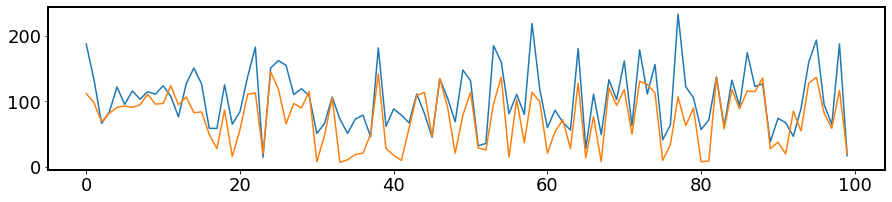

In [535]:
prediction = model.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction.T[0]))
ax.plot(test_Y)

results['NeuralNetwork'] = get_score(test_Y,prediction);

<AxesSubplot:>

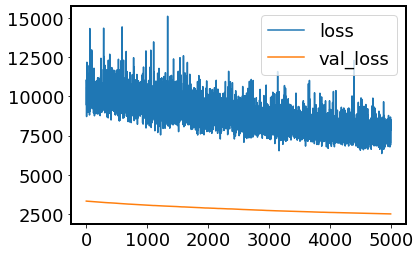

In [536]:
pd.DataFrame(history.history).drop(columns=['mse','val_mse']).plot()

---

Competition Score: 684.8434295815175
MSE: 431.66120872348006
R2 score: 0.7500325393860195
MAE: 16.762939653133042
CPU times: total: 15.6 ms
Wall time: 20.1 ms


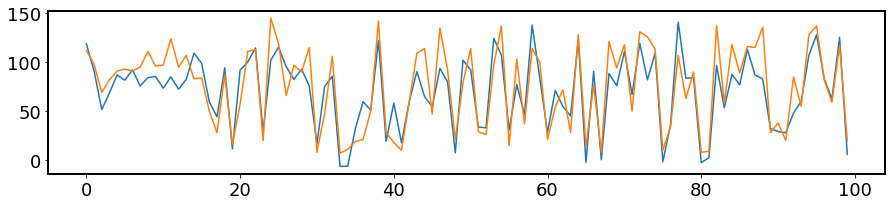

In [191]:
%%time
regr = LinearSVR(C=0.0098,loss='epsilon_insensitive',fit_intercept=True,epsilon=2,tol=10e-10)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['LinearSVR'] = get_score(test_Y,prediction);

Competition Score: 10827.636317597247
MSE: 973.6308264554619
R2 score: 0.43618740728572547
MAE: 24.799507774312456
CPU times: total: 1.78 s
Wall time: 1.29 s


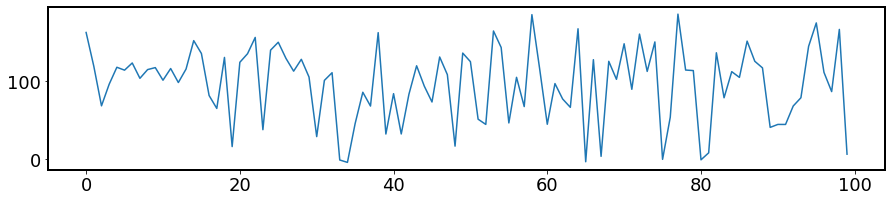

In [189]:
%%time
regr = MLPRegressor(hidden_layer_sizes=(100,50,50),
                                    activation='identity',
                                    warm_start=True,
                                    verbose=False,
                                    solver='adam',
                                    learning_rate_init=0.001,
                                    max_iter=200)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['MLPRegressor'] = get_score(test_Y,prediction);

Competition Score: 58324857.16831399
MSE: 2162.01
R2 score: -0.25198219946659584
MAE: 31.87
Wall time: 333 ms


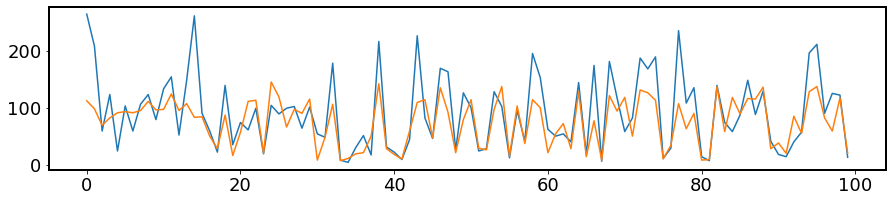

In [118]:
%%time
regr = DecisionTreeRegressor()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['DecisionTreeRegressor'] = get_score(test_Y,prediction);

Competition Score: 11285.294325213059
MSE: 947.8491525117643
R2 score: 0.4511171240076468
MAE: 24.602904970556622
Wall time: 58.8 ms


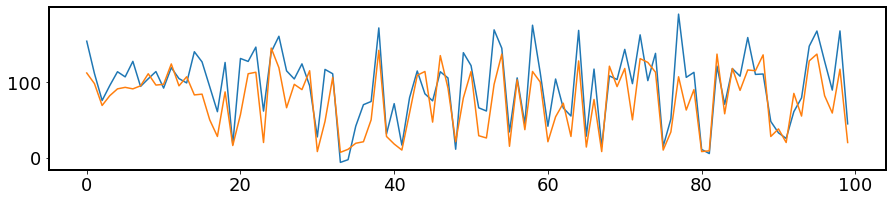

In [119]:
%%time
regr = PLSRegression(n_components=1)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction.T[0]))
ax.plot(test_Y)

results['PLSRegression'] = get_score(test_Y,prediction.T[0]);

Competition Score: 8781.142852174653
MSE: 957.8302300166204
R2 score: 0.4453372564919664
MAE: 24.96756842105263
Wall time: 375 ms


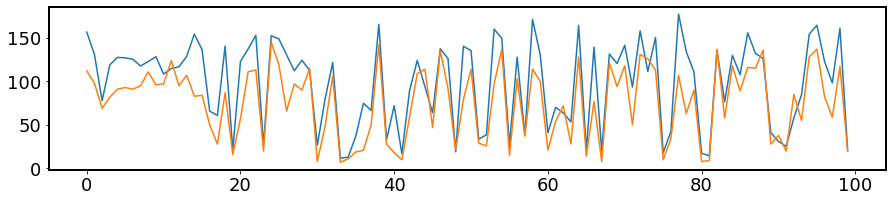

In [120]:
%%time
regr = KNeighborsRegressor(n_neighbors=950,leaf_size=30)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['KNeighborsRegressor'] = get_score(test_Y,prediction);

Competition Score: 6370.707700515507
MSE: 947.3740086784584
R2 score: 0.4513922714960883
MAE: 26.100794669012135
Wall time: 82.8 ms


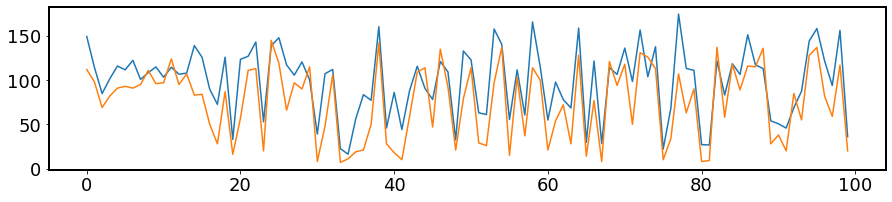

In [121]:
%%time
regr = linear_model.SGDRegressor(alpha=1,epsilon=5,verbose=0)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['SGDRegressor'] = get_score(test_Y,prediction);

Competition Score: 1447.5426485915011
MSE: 453.4021595980321
R2 score: 0.7374427347623513
MAE: 16.898235452788516
Wall time: 1min 8s


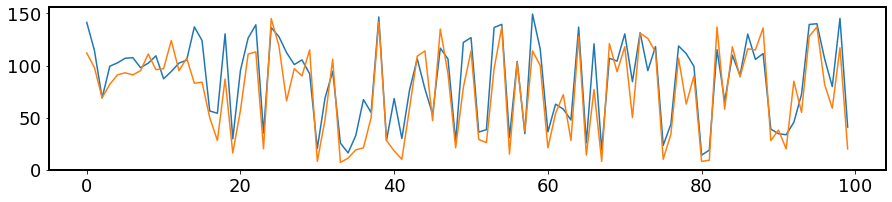

In [122]:
%%time
regr = NuSVR(nu=0.95,C=0.06)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['NuSVR'] =get_score(test_Y,prediction);

Competition Score: 1455.6358438973248
MSE: 453.99749911954837
R2 score: 0.7370979840518657
MAE: 16.898575895516682
Wall time: 37 s


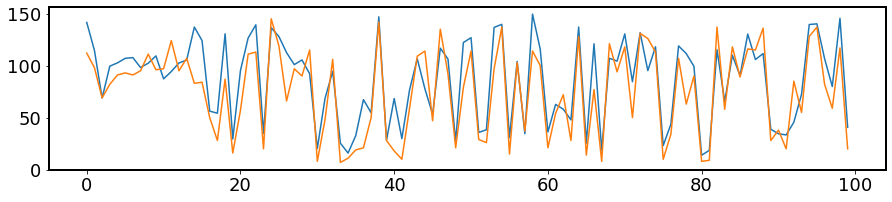

In [123]:
%%time
regr = SVR(C=0.06, epsilon=0.1)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['SVR'] =get_score(test_Y,prediction);

Competition Score: 18312.7899409674
MSE: 1009.2706741159948
R2 score: 0.4155489944834312
MAE: 24.25680889958304
Wall time: 220 ms


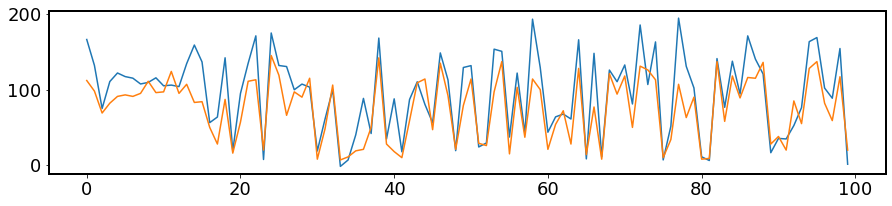

In [124]:
%%time
poly = PolynomialFeatures(degree=3)
train = poly.fit_transform(train_X_std)
test = poly.fit_transform(test_X_std)

regr = linear_model.LinearRegression()
regr.fit(train, train_Y)
prediction = regr.predict(test)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['PolynomialFeatures_3dg'] = get_score(test_Y,prediction);

Competition Score: 11592.572120654808
MSE: 1017.4719370427076
R2 score: 0.4107997864791251
MAE: 25.751217964696266
Wall time: 9.92 s


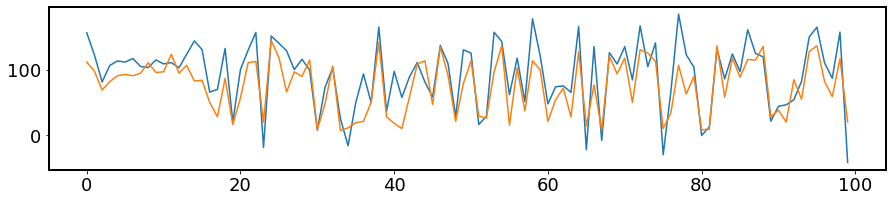

In [125]:
%%time
regr = linear_model.TheilSenRegressor()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['TheilSenRegressor'] =get_score(test_Y,prediction);

Competition Score: 31480.24093406367
MSE: 1213.4919155133757
R2 score: 0.297288043339592
MAE: 26.09387552901559
Wall time: 285 ms


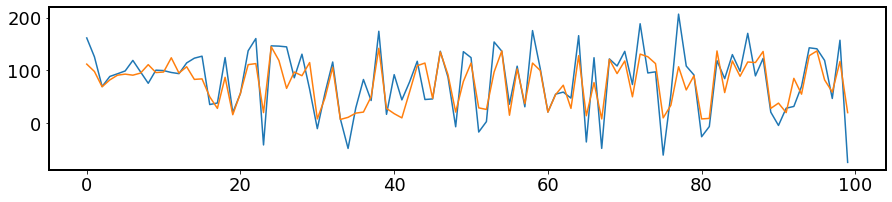

In [126]:
%%time
regr = linear_model.RANSACRegressor()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['RANSACRegressor'] =get_score(test_Y,prediction);

Competition Score: 3872.395358661672
MSE: 669.216084734328
R2 score: 0.6124686631032661
MAE: 20.15713199041642
Wall time: 217 ms


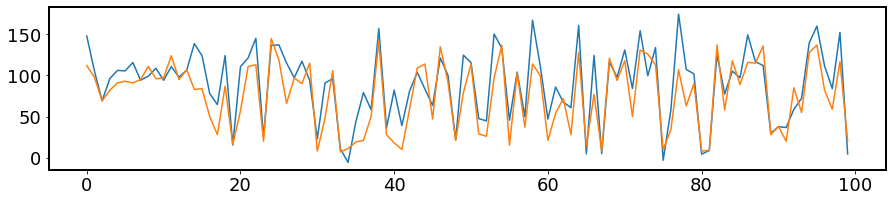

In [127]:
%%time
regr = linear_model.HuberRegressor(epsilon=1)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['HuberRegressor'] = get_score(test_Y,prediction);

Competition Score: 9722.580137365825
MSE: 983.9811034231311
R2 score: 0.43019374281466805
MAE: 25.16610630890799
Wall time: 58.8 ms


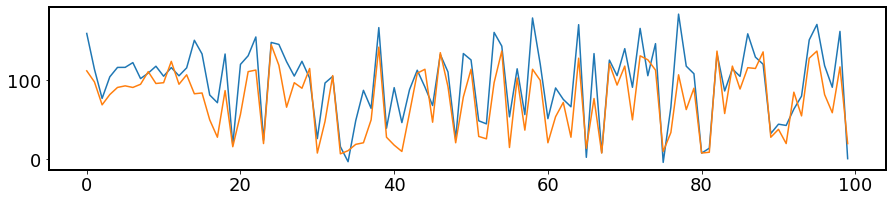

In [128]:
%%time
regr = linear_model.LinearRegression()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)


results['LinearRegression'] = get_score(test_Y,prediction);

Competition Score: 9706.753233051333
MSE: 983.500645842218
R2 score: 0.43047196740146554
MAE: 25.16204041840275
Wall time: 57.3 ms


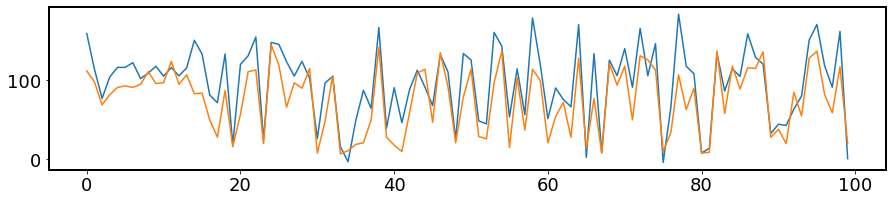

In [129]:
%%time
regr = linear_model.BayesianRidge()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['BayesianRidge'] = get_score(test_Y,prediction);

C:\Users\BERNARDO\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Competition Score: 191812.12313109834
MSE: 978.9
R2 score: 0.4331361209902588
MAE: 22.26
Wall time: 47.5 s


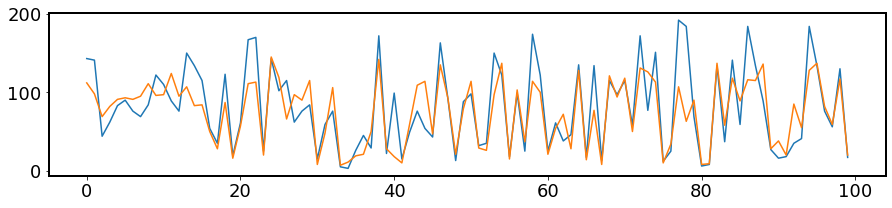

In [130]:
%%time
regr = linear_model.LogisticRegression()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['LogisticRegression'] = get_score(test_Y,prediction);

Competition Score: 9721.88088732014
MSE: 983.9598759303627
R2 score: 0.4302060352846776
MAE: 25.165927070751685
Wall time: 59.8 ms


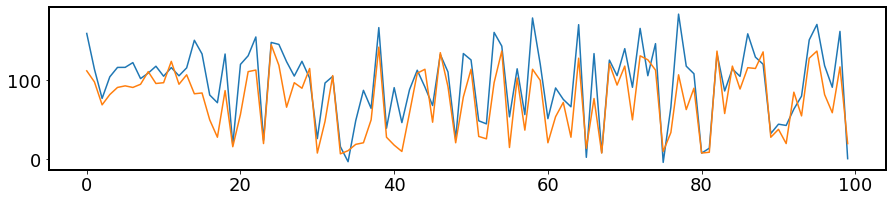

In [131]:
%%time
regr = linear_model.Ridge()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['Ridge'] = get_score(test_Y,prediction);

Competition Score: 52890.72471902489
MSE: 1126.8752709999999
R2 score: 0.34744622813442305
MAE: 23.888100000000005
Wall time: 18.1 s


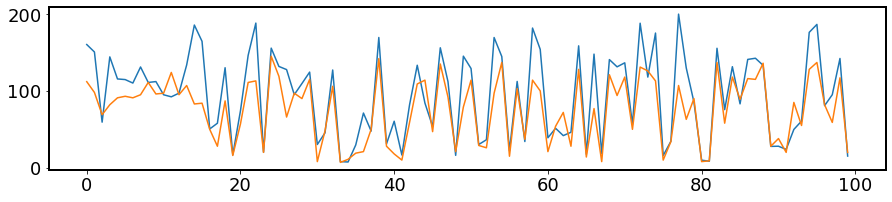

In [132]:
%%time
regr = RandomForestRegressor()
regr.fit(train_X, train_Y)
prediction = regr.predict(test_X)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['RandomForestRegressor'] = get_score(test_Y,prediction);

In [133]:
res = pd.DataFrame(results).T.rename(columns={0:'Competition_Score',1:'MSE',2:'R2_score',3:'MAE'})

In [134]:
res = res.sort_values('Competition_Score')

In [135]:
res

,Competition_Score,MSE,R2_score,MAE
LinearSVR,7.976307e+02,406.817474,0.764419,15.988280
NuSVR,1.447543e+03,453.402160,0.737443,16.898235
SVR,1.455636e+03,453.997499,0.737098,16.898576
HuberRegressor,3.872395e+03,669.216085,0.612469,20.157132
SGDRegressor,6.370708e+03,947.374009,0.451392,26.100795
MLPRegressor,6.661890e+03,867.389798,0.497710,23.730849
KNeighborsRegressor,8.781143e+03,957.830230,0.445337,24.967568
BayesianRidge,9.706753e+03,983.500646,0.430472,25.162040
Ridge,9.721881e+03,983.959876,0.430206,25.165927
LinearRegression,9.722580e+03,983.981103,0.430194,25.166106


In [169]:
res.to_excel('results/FD001_results.xlsx')

#### To do
- Retirar colunas de alta correlação
- Transformar colunas binarias em categóricas
- Ligar com outliers (skewness)